<h3>Introducción</h3>
En este Notebook se utilizará el código <a href = "https://github.com/feos-org/feos"> $\mathrm{FeO_s}$</a> v0.3.0 para simular la adsorción de hidrógeno puro mediante la Teoría del Funcional de la Densidad Clásica. Para esto se necesita tener instalado el código $\mathrm{FeO_s}$, así como, numpy y matplotlib.

In [1]:
from feos.si import *     
from feos.pcsaft import * 
from feos.dft import *    

import numpy as np 
import matplotlib.pyplot as plt 

Debido a que en el Notebook anterior se mostró como determinar los parámetros SAFT, en este Notebook se utilizan directamente. Lo primero es definir el compuesto "hydrogen" de acuerdo a lo mostrado <a href = "https://github.com/feos-org/feos/blob/main/examples/pcsaft_working_with_parameters.ipynb"> aquí</a>.

In [2]:
m=1.0 
s=3.105
e=28.256

identifier = Identifier(name='hydrogen')
psr = PcSaftRecord(m, s, e)
hydrogen = PureRecord(identifier, molarweight=2.016, model_record=psr)
parameters = PcSaftParameters.new_pure(hydrogen)
parameters

|component|molarweight|$m$|$\sigma$|$\varepsilon$|$\mu$|$Q$|$\kappa_{AB}$|$\varepsilon_{AB}$|$N_A$|$N_B$|
|-|-|-|-|-|-|-|-|-|-|-|
|hydrogen|2.016|1|3.105|28.256|0|0|0|0|1|1|

Luego se define el funcional a utilizar, en este caso se utiliza el funcional "WhiteBear" para PC-SAFT. También existe la posibilidad de utilizar el funcional "AntiSymWhiteBear" o "KierlikRosinberg".

In [3]:
func = HelmholtzEnergyFunctional.pcsaft(parameters, FMTVersion.WhiteBear)

Una vez definido el funcional se pueden determinar los perfiles de densidad del hidrógeno. Para esto se emplea un "solver" que realizará la iteración de Piccard con un coeficiente de 0.05, en general esto no es necesario modificar. El potencial del sólido se define en la variable "potential", se utiliza un potencial de Steele con $\sigma_{ss}$ = 3.4 Å,  $\varepsilon_{ss}/k_B$ = 28 K y $\rho_{s}$ = 0.114 Å$^3$ estos parámetros pueden ser modificados, al igual que el potencial escogido <a href = "https://feos-org.github.io/feos/api/generated/feos.dft.ExternalPotential.html#feos.dft.ExternalPotential"> (Steele, Lennard-Jones)</a>.

La temperatura de la adsorción y el tamaño del poro se definen en "Temp" y "Psize", respectivamente. El código $\mathrm{FeO_s}$ utiliza magnitudes con unidades físicas del SI por lo que deben multiplicarse por "KELVIN" y "ANGSTROM", como puede observarse en este <a href = "https://github.com/feos-org/feos/blob/main/examples/core_working_with_units.ipynb"> ejemplo</a>, lo mismo ocurre para la presión que debe multiplicarse por "BAR".

In [4]:
solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
#potential = ExternalPotential.LJ93(3.844, 37.575, 0.05) # https://doi.org/10.1063/1.5096804

Temp = 77*KELVIN
Psize= 20*ANGSTROM

Para obtener los perfiles a diferentes presiones se usa "for" para las diferentes presiones. "bulk" utiliza la función `State` para obtener el estado termodinámico del compuesto en el seno, esta función requiere que se especifique la ecuación de estado a utilizar junto con su funcional (func), la temperatura (Temp) y la presión, en este caso se utilizan 5 presiones diferentes [1, 5, 20, 100, 200].

Luego en "poro" se utiliza la función `Pore1D` para definir el poro tipo hendidura, para esto se debe especificar la geometría (Geometry.Cartesian), el tamaño de poro (Psize) y el potencial del sólido a usar (potential). Despues en "poro2" se resuelve la distribucion de las densidades del compuesto al interior del poro, utilizando "solver" y "bulk" como primera aproximación.
Se puede investigar el uso de diferentes geometrías según este <a href = "https://github.com/feos-org/feos/blob/main/examples/pcsaft/pore_geometry.ipynb"> ejemplo</a>, pero esto no siempre da buenos resultados.

En "poro2" se almacenan las densidades y la posición (z) del compuesto. La posición se obtiene con "poro2.z" y la densidad con "poro2.density", para graficar ambas hay que volverlas adimensionales, por lo que se debe dividir por sus unidades correspondientes. De esta forma, se obtienen los perfiles de densidad.

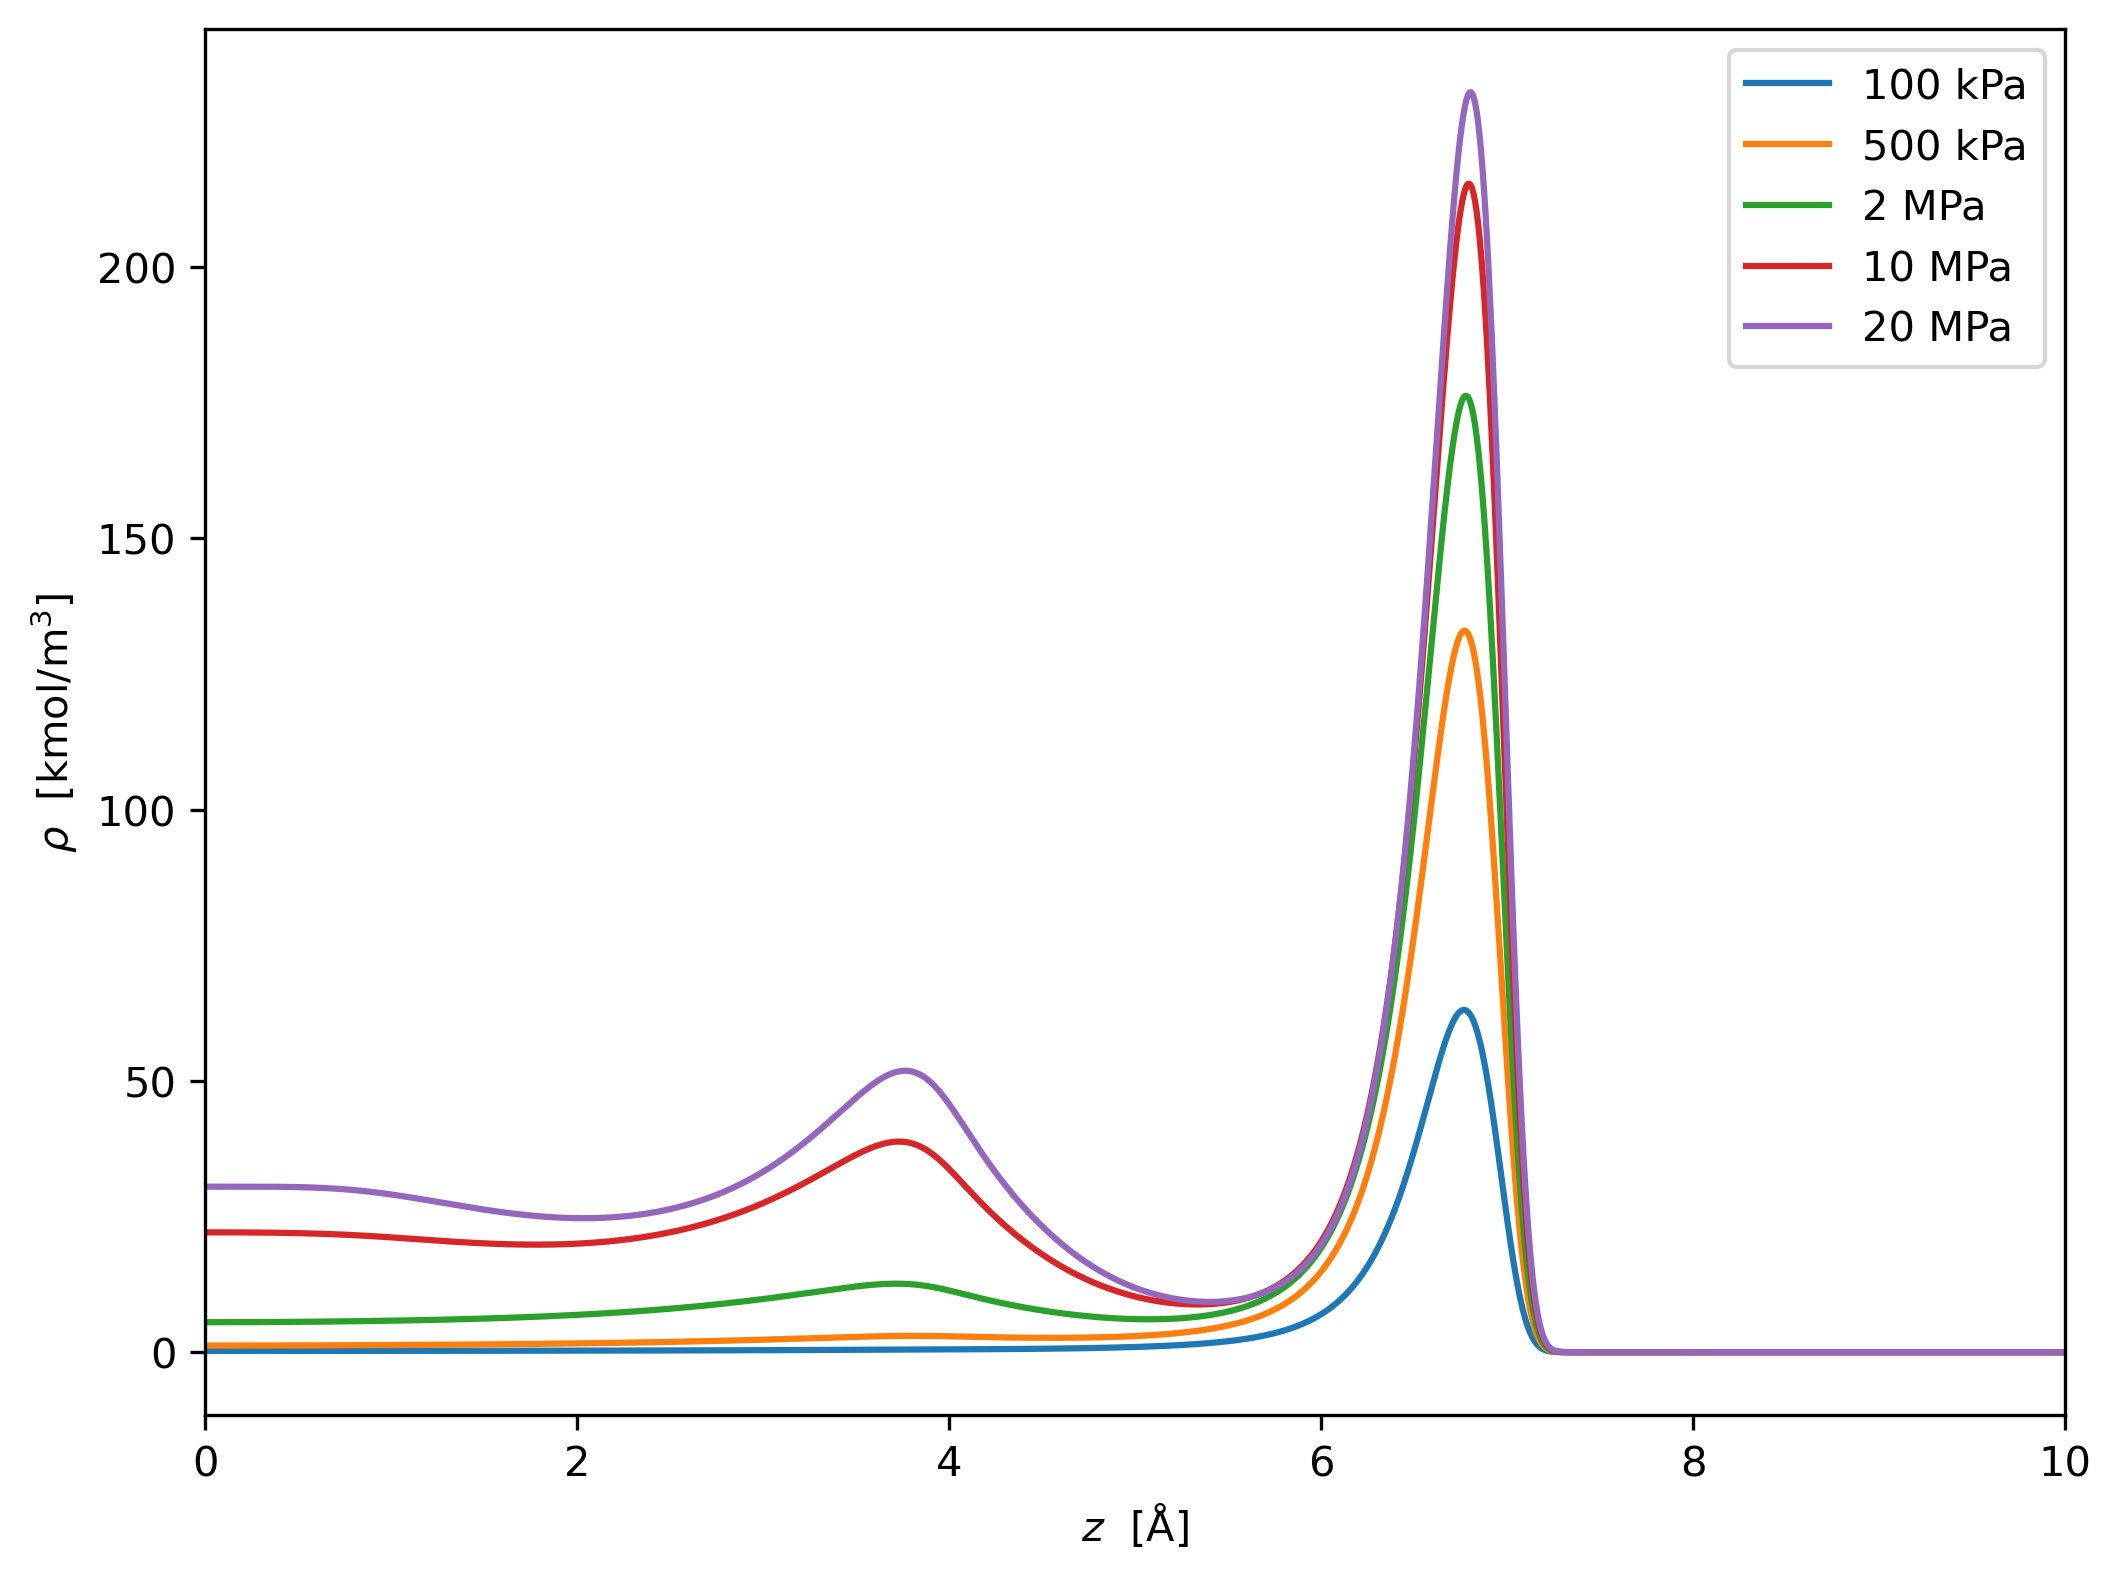

In [5]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

for i in [1, 5, 20, 100, 200]:
    bulk = State(func, Temp, pressure=i*BAR)
    poro = Pore1D(Geometry.Cartesian, Psize, potential)
    poro2= poro.initialize(bulk).solve(solver)
    plt.plot(poro2.z/(ANGSTROM), (poro2.density*(METER**3/MOL)/1000).T, 
         label="{}".format(i * BAR))

plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [kmol/m$^3$]")
plt.xlim(0, 10)
#plt.suptitle('Perfiles de densidad para H$_2$ a {} en un poro de {}'.format(Temp, Psize))
plt.show()

En el siguiente gráfico se realiza el mismo procedimiento anterior, pero se agranda el tamaño del poro para demostrar que la densidad del compuesto en la mitad del poro (lo suficientemente lejos del potencial externo) corresponde a la densidad en el seno del fluido. Los datos para realizar la comparación fueron tomados del <a href = "https://webbook.nist.gov/cgi/fluid.cgi?T=77&PLow=1&PHigh=20&PInc=1&Digits=5&ID=C1333740&Action=Load&Type=IsoTherm&TUnit=K&PUnit=MPa&DUnit=mol%2Fl&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF"> NIST</a>.


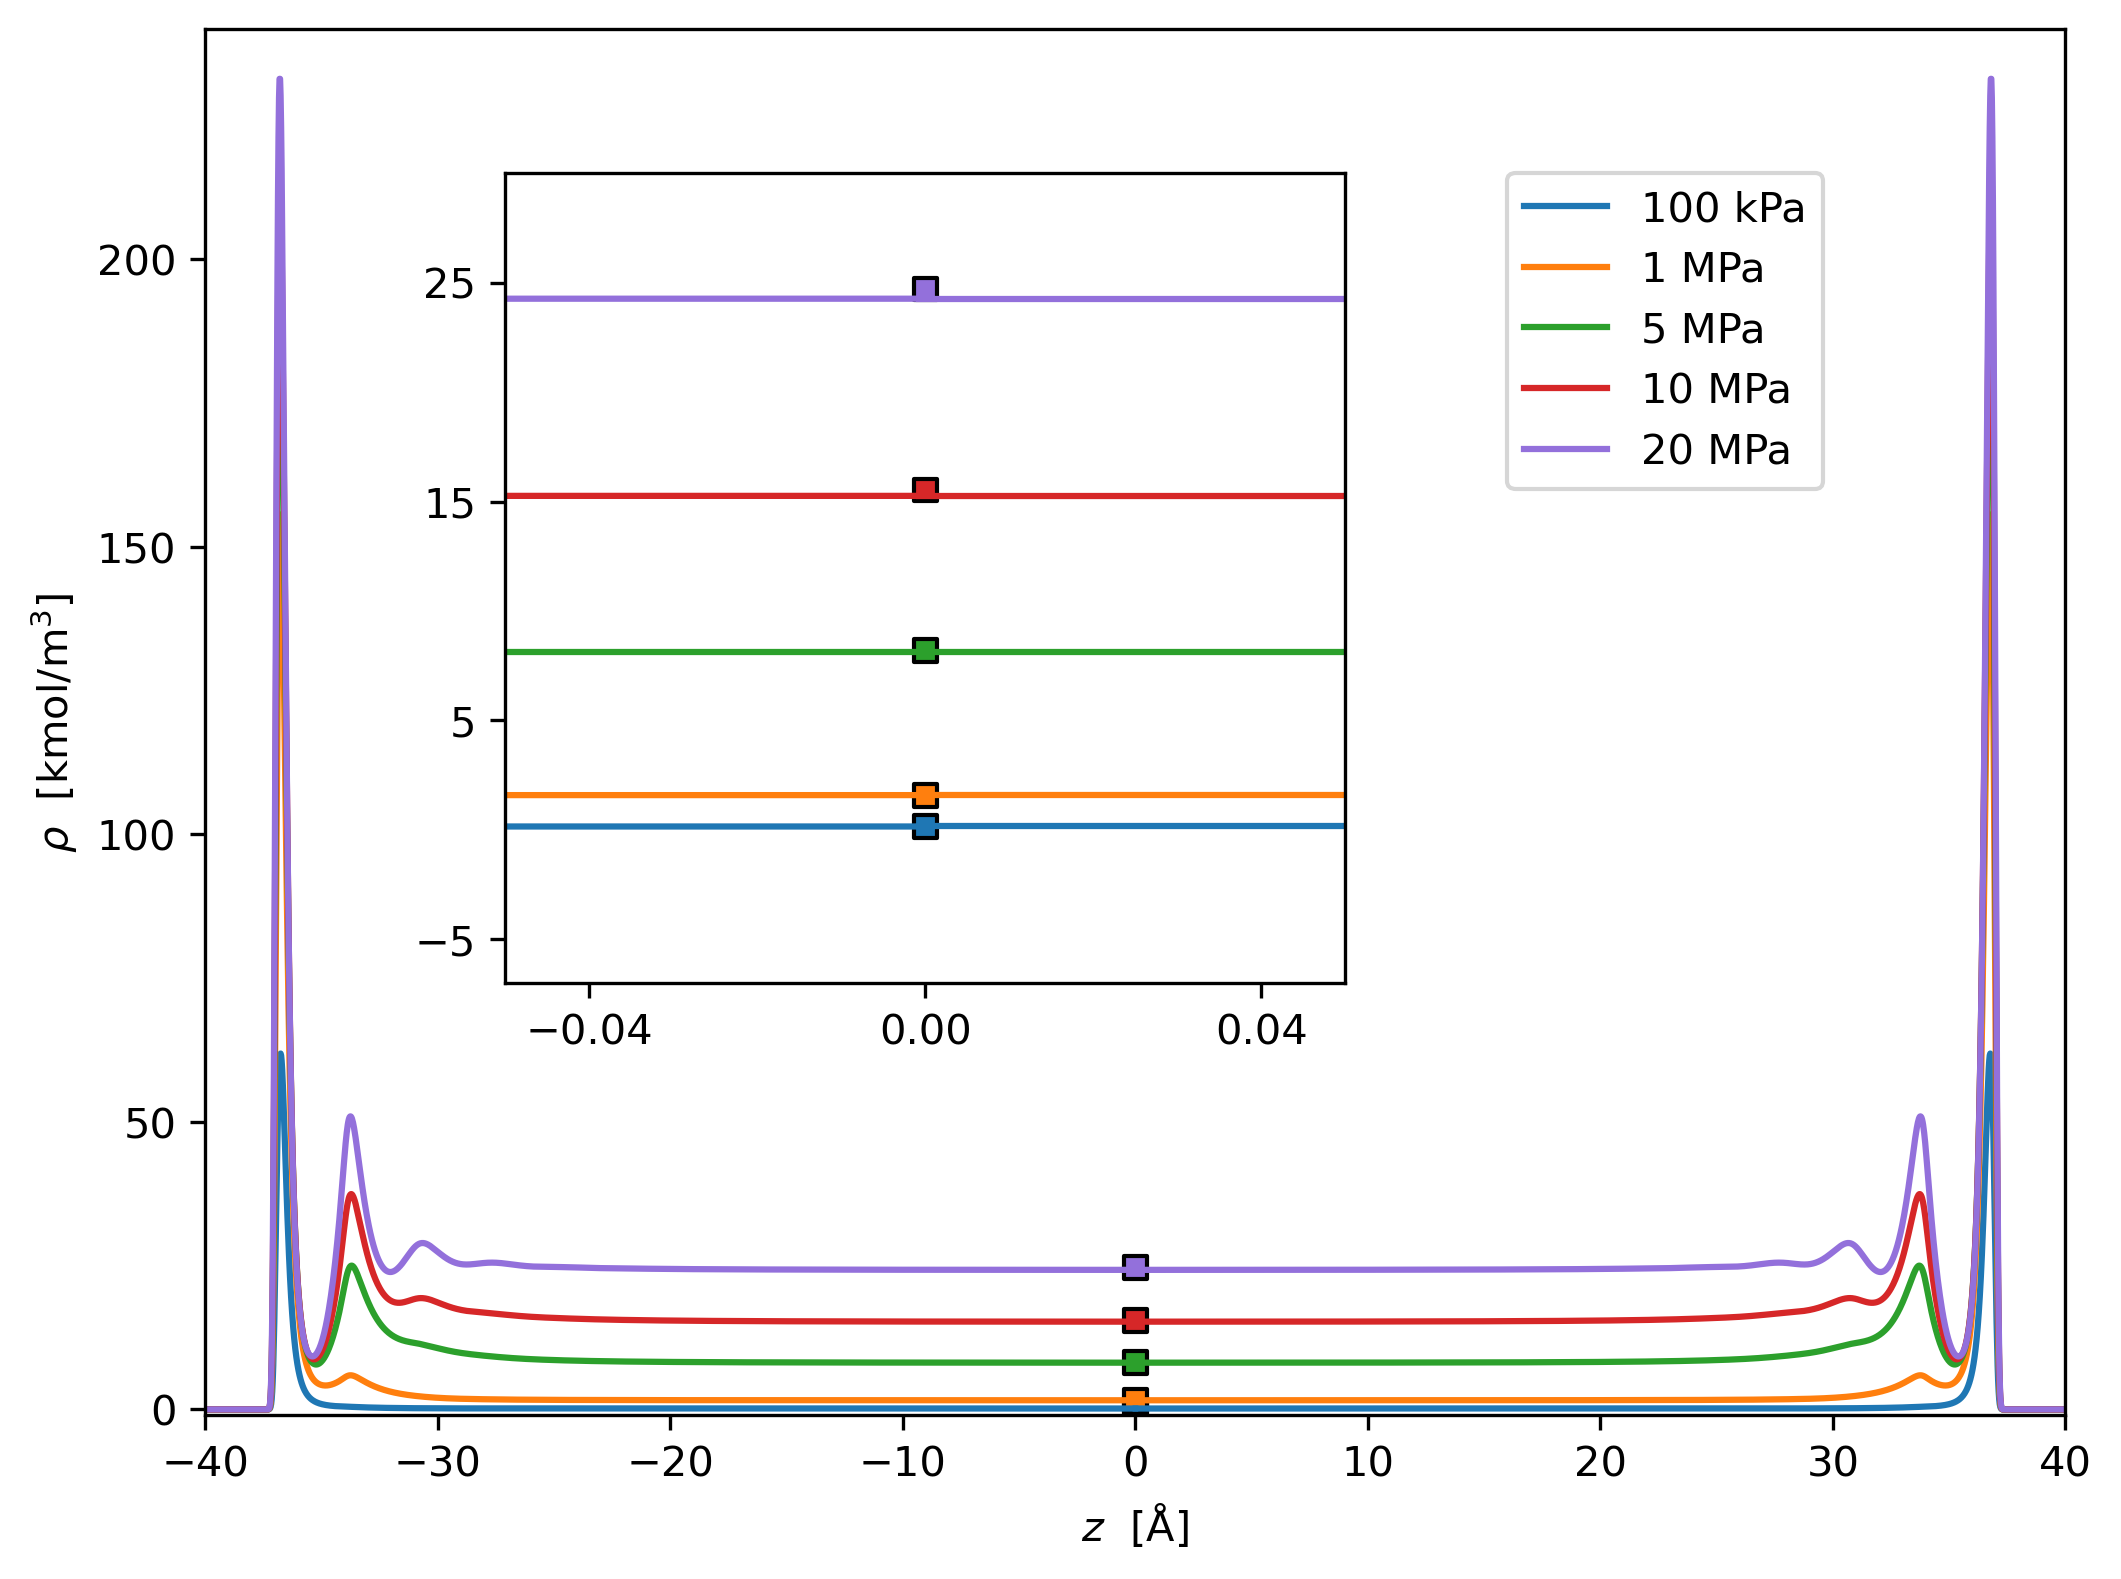

In [6]:
fig, ax1 = plt.subplots(dpi=300)
left, bottom, width, height = [0.25, 0.35, 0.35, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])
fig.set_figwidth(8)
fig.set_figheight(6)

temp = 77*KELVIN
psize= 80*ANGSTROM
solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
#potential = ExternalPotential.LJ93(3.844, 37.575, 0.05) # https://doi.org/10.1063/1.5096804

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]

for j, i in enumerate([1, 10, 50, 100, 200]):
    bulk = State(func, temp, pressure=i*BAR)
    porex = Pore1D(Geometry.Cartesian, psize, potential).initialize(bulk).solve(solver)
   
    ax1.plot(porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000).T, color=colors[j],
         label="{}".format(i * BAR))
    ax1.plot(-porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000).T, color=colors[j])
    ax2.plot(porex.z/(ANGSTROM)-0.012, (porex.density*(METER**3/MOL)/1000).T, color=colors[j],
         label="{}".format(i * BAR))
    ax2.plot(-porex.z/(ANGSTROM)+0.012, (porex.density*(METER**3/MOL)/1000).T, color=colors[j])

# 0,0 is bottom left)

cer=[0,0,0,0,0]
den=[0.15645,1.5867,8.1830,15.528,24.712]
ax2.scatter(cer, den, marker='s', color=colors, s=30, linewidths=1, edgecolor="k")   
ax2.set_xlim(-0.05, 0.05)
ax2.set_ylim(-7, 30)
ax2.set_xticks([-0.04, 0, 0.04])
ax2.set_yticks([-5, 5, 15, 25])

ax1.scatter(cer, den, marker='s', color=colors, s=30, linewidths=1, edgecolor="k") 
ax1.legend(loc=(0.7,0.668), numpoints=1)  
ax1.set_xlabel(r"$z$  [Å]")
ax1.set_ylabel(r"$\rho$  [kmol/m$^3$]")
ax1.set_xlim(-40, 40)
ax1.set_ylim(-1, 240)
#plt.suptitle('Perfiles de densidad para H2 a {} en un poro de {}'.format(temp, psize))
plt.show()

A continuación se muestra la comparación realizada con los resultados de <a href = "https://pubs.acs.org/doi/10.1021/jp9829602"> Rzepka $et$ $al.$</a>. Para obtener los valores se utilizó un software de captura de datos.

In [7]:
Rzepka_z20=[-7.51, -7.0, -6.8, -6.61, -6.0, -4.51, -3.0, -1.01, 0.0, 2.01, 4.01, 4.99, 6.01, 6.59, 6.83, 7.01, 7.55]
Rzepka_d20=[-0.01, 18.1, 31.9, 32.61, 20.14, 8.67, 8.22, 7.96, 8.14, 8.19, 8.24, 11.2, 19.52, 31.55, 30.52, 18.88, -0.09]

Rzepka_z14=[-4.39, -4.0, -3.66, -2.6, -3.2, -1.01, 1.01, 2.0, 3.0, 3.64, 4.0, 4.39]
Rzepka_d14=[0.1, 13.14, 34.61, 14.36, 24.64, 9.82, 10.2, 11.01, 20.04, 34.54, 15.81, 0.09]

En este gráfico se sigue el mismo procedimiento de los casos anteriores cuidando de utilizar las mismas condiciones reportadas por Rzepka $et$ $al.$ y transformando las unidades a $kg/m^3$. En este caso, los cálculos se hacen para diferentes tamaños de poros en vez de presiones.

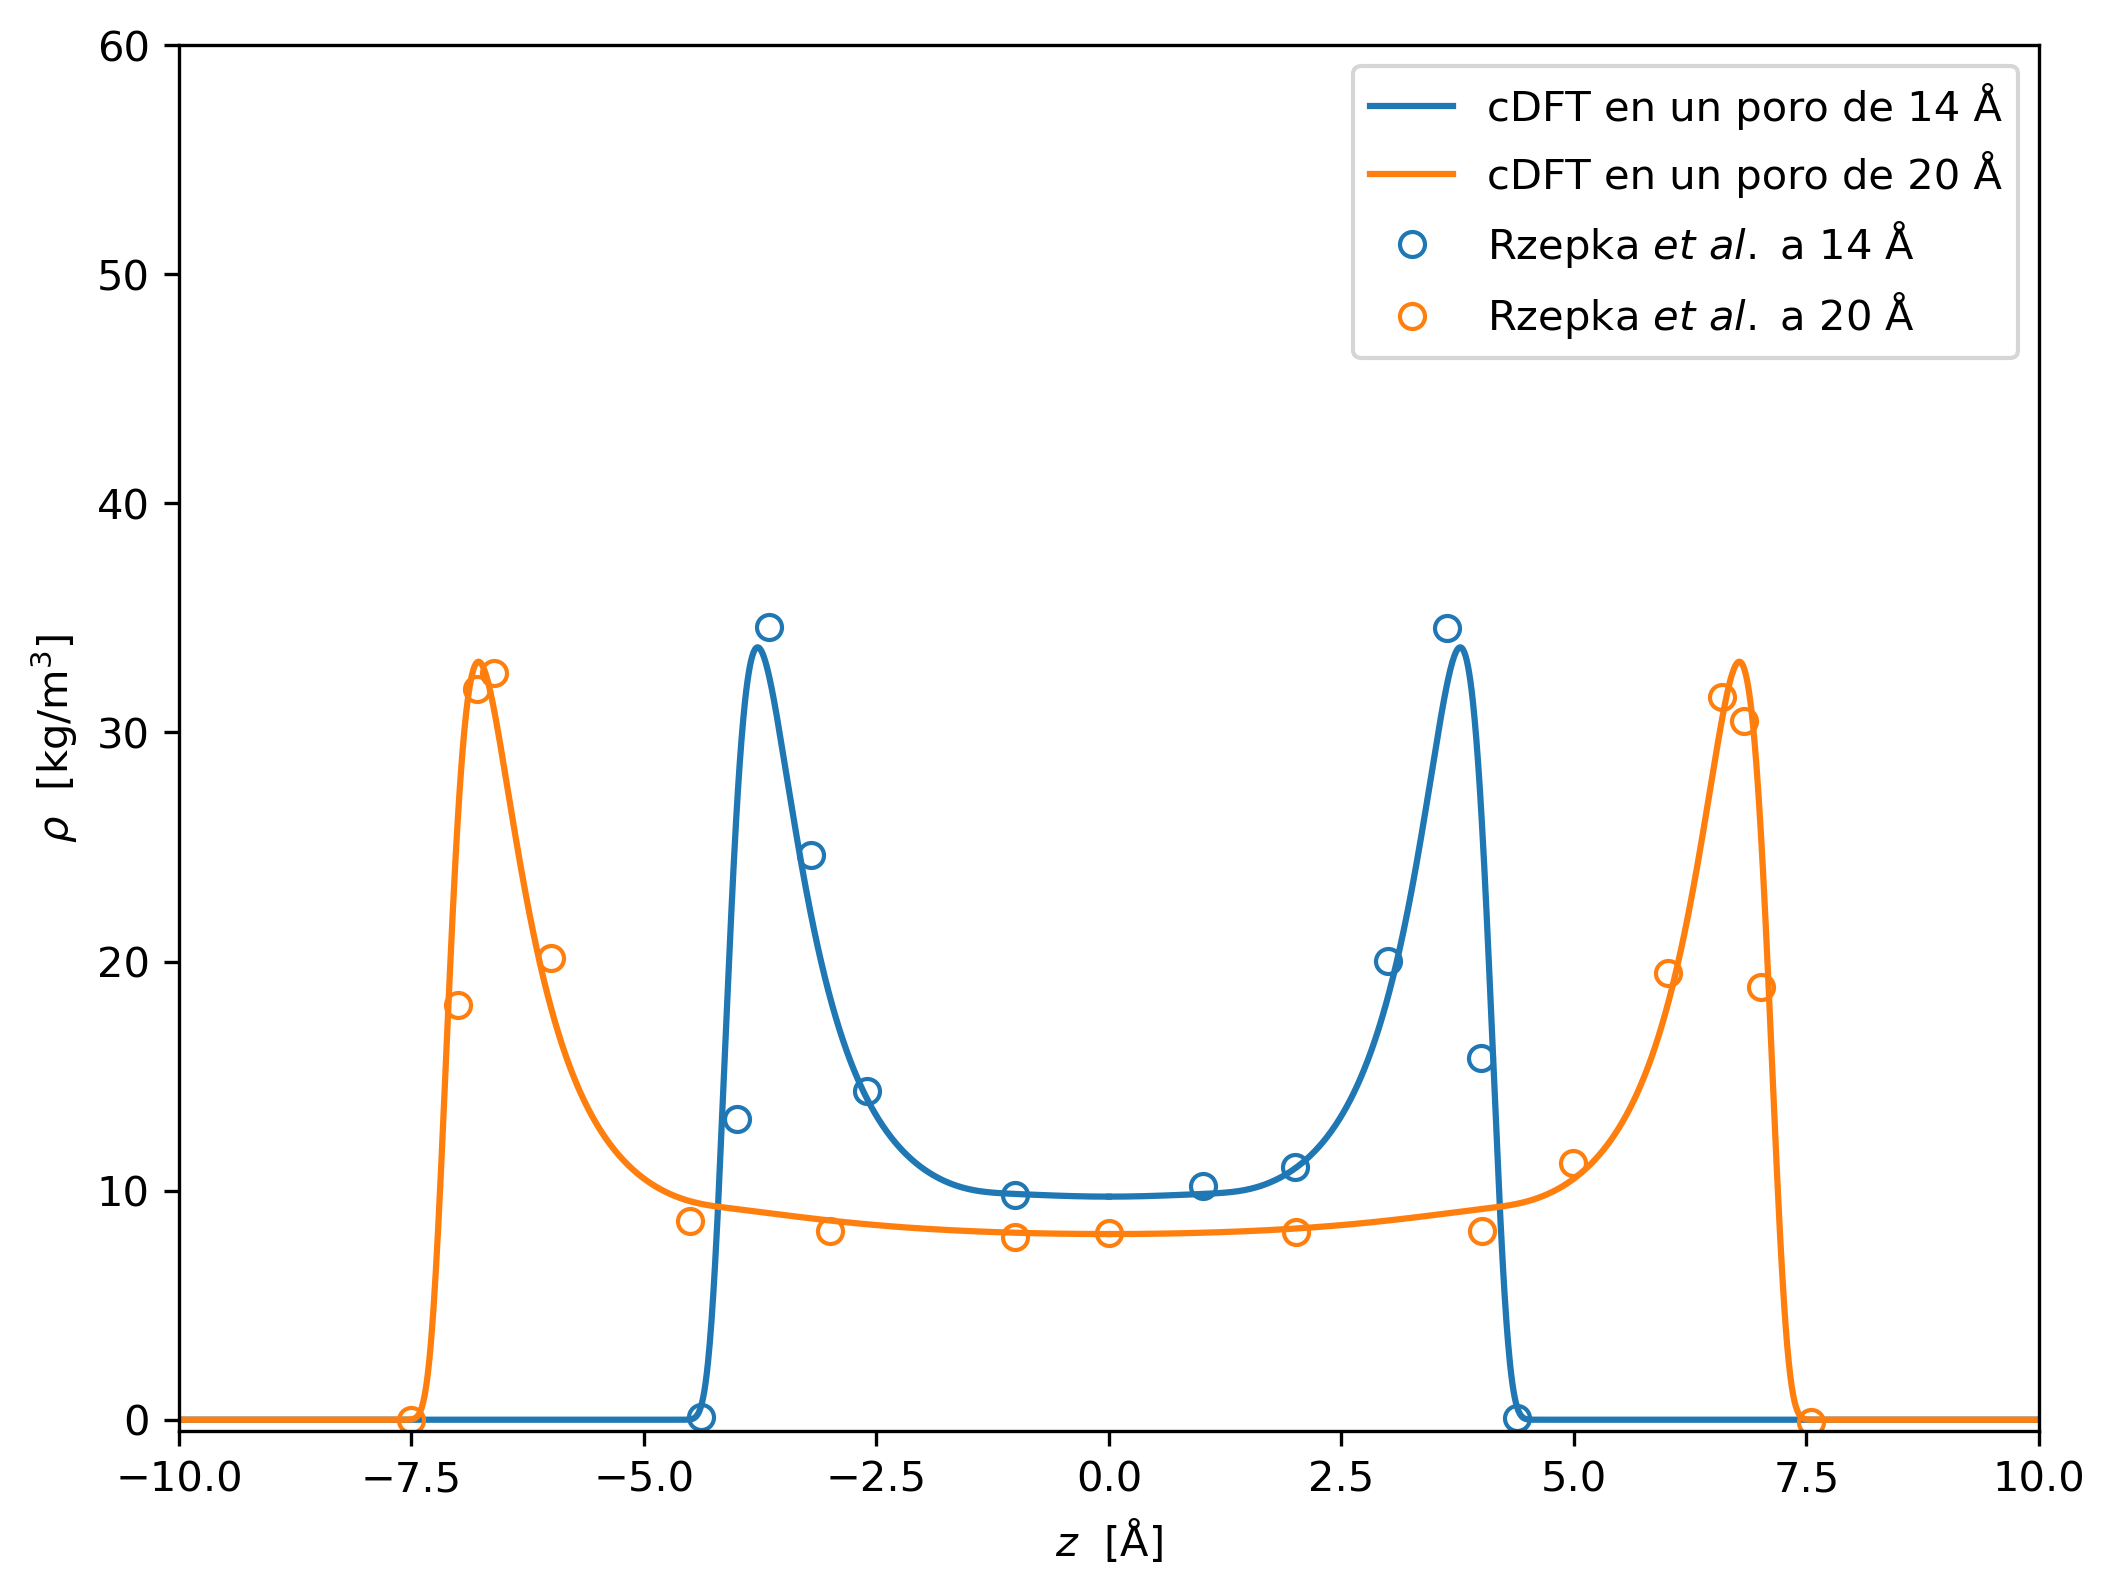

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

temp = 300*KELVIN
pres = 100*BAR

solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.05).anderson_mixing()
potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]

for j, i in enumerate([14, 20]):
    bulk = State(func, temp, pressure=pres)
    porex = Pore1D(Geometry.Cartesian, i*ANGSTROM, potential).initialize(bulk).solve(solver)
   
    plt.plot(porex.z/(ANGSTROM), np.multiply((porex.density*(METER**3/MOL)/1000).T,2.016), 
                color=colors[j],label="cDFT en un poro de {} Å".format(i))
    plt.plot(-porex.z/(ANGSTROM), np.multiply((porex.density*(METER**3/MOL)/1000).T,2.016), color=colors[j])

plt.plot(Rzepka_z14, Rzepka_d14, label="Rzepka $et$ $al.$ a 14 Å", color="tab:blue", marker="o", linestyle="None", mfc="None")
plt.plot(Rzepka_z20, Rzepka_d20, label="Rzepka $et$ $al.$ a 20 Å", color="tab:orange", marker="o", linestyle="None", mfc="None")

plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [kg/m$^3$]")
plt.xlim(-10,10)
plt.ylim(-0.5, 60)
#plt.suptitle('Perfiles de densidad para H$_2$ a {} y {}'.format(temp, pres))
plt.show()

Para estudiar sólo el efecto de los tamaños de poros, se grafican diferentes casos siguiendo el mismo procedimiento anterior.

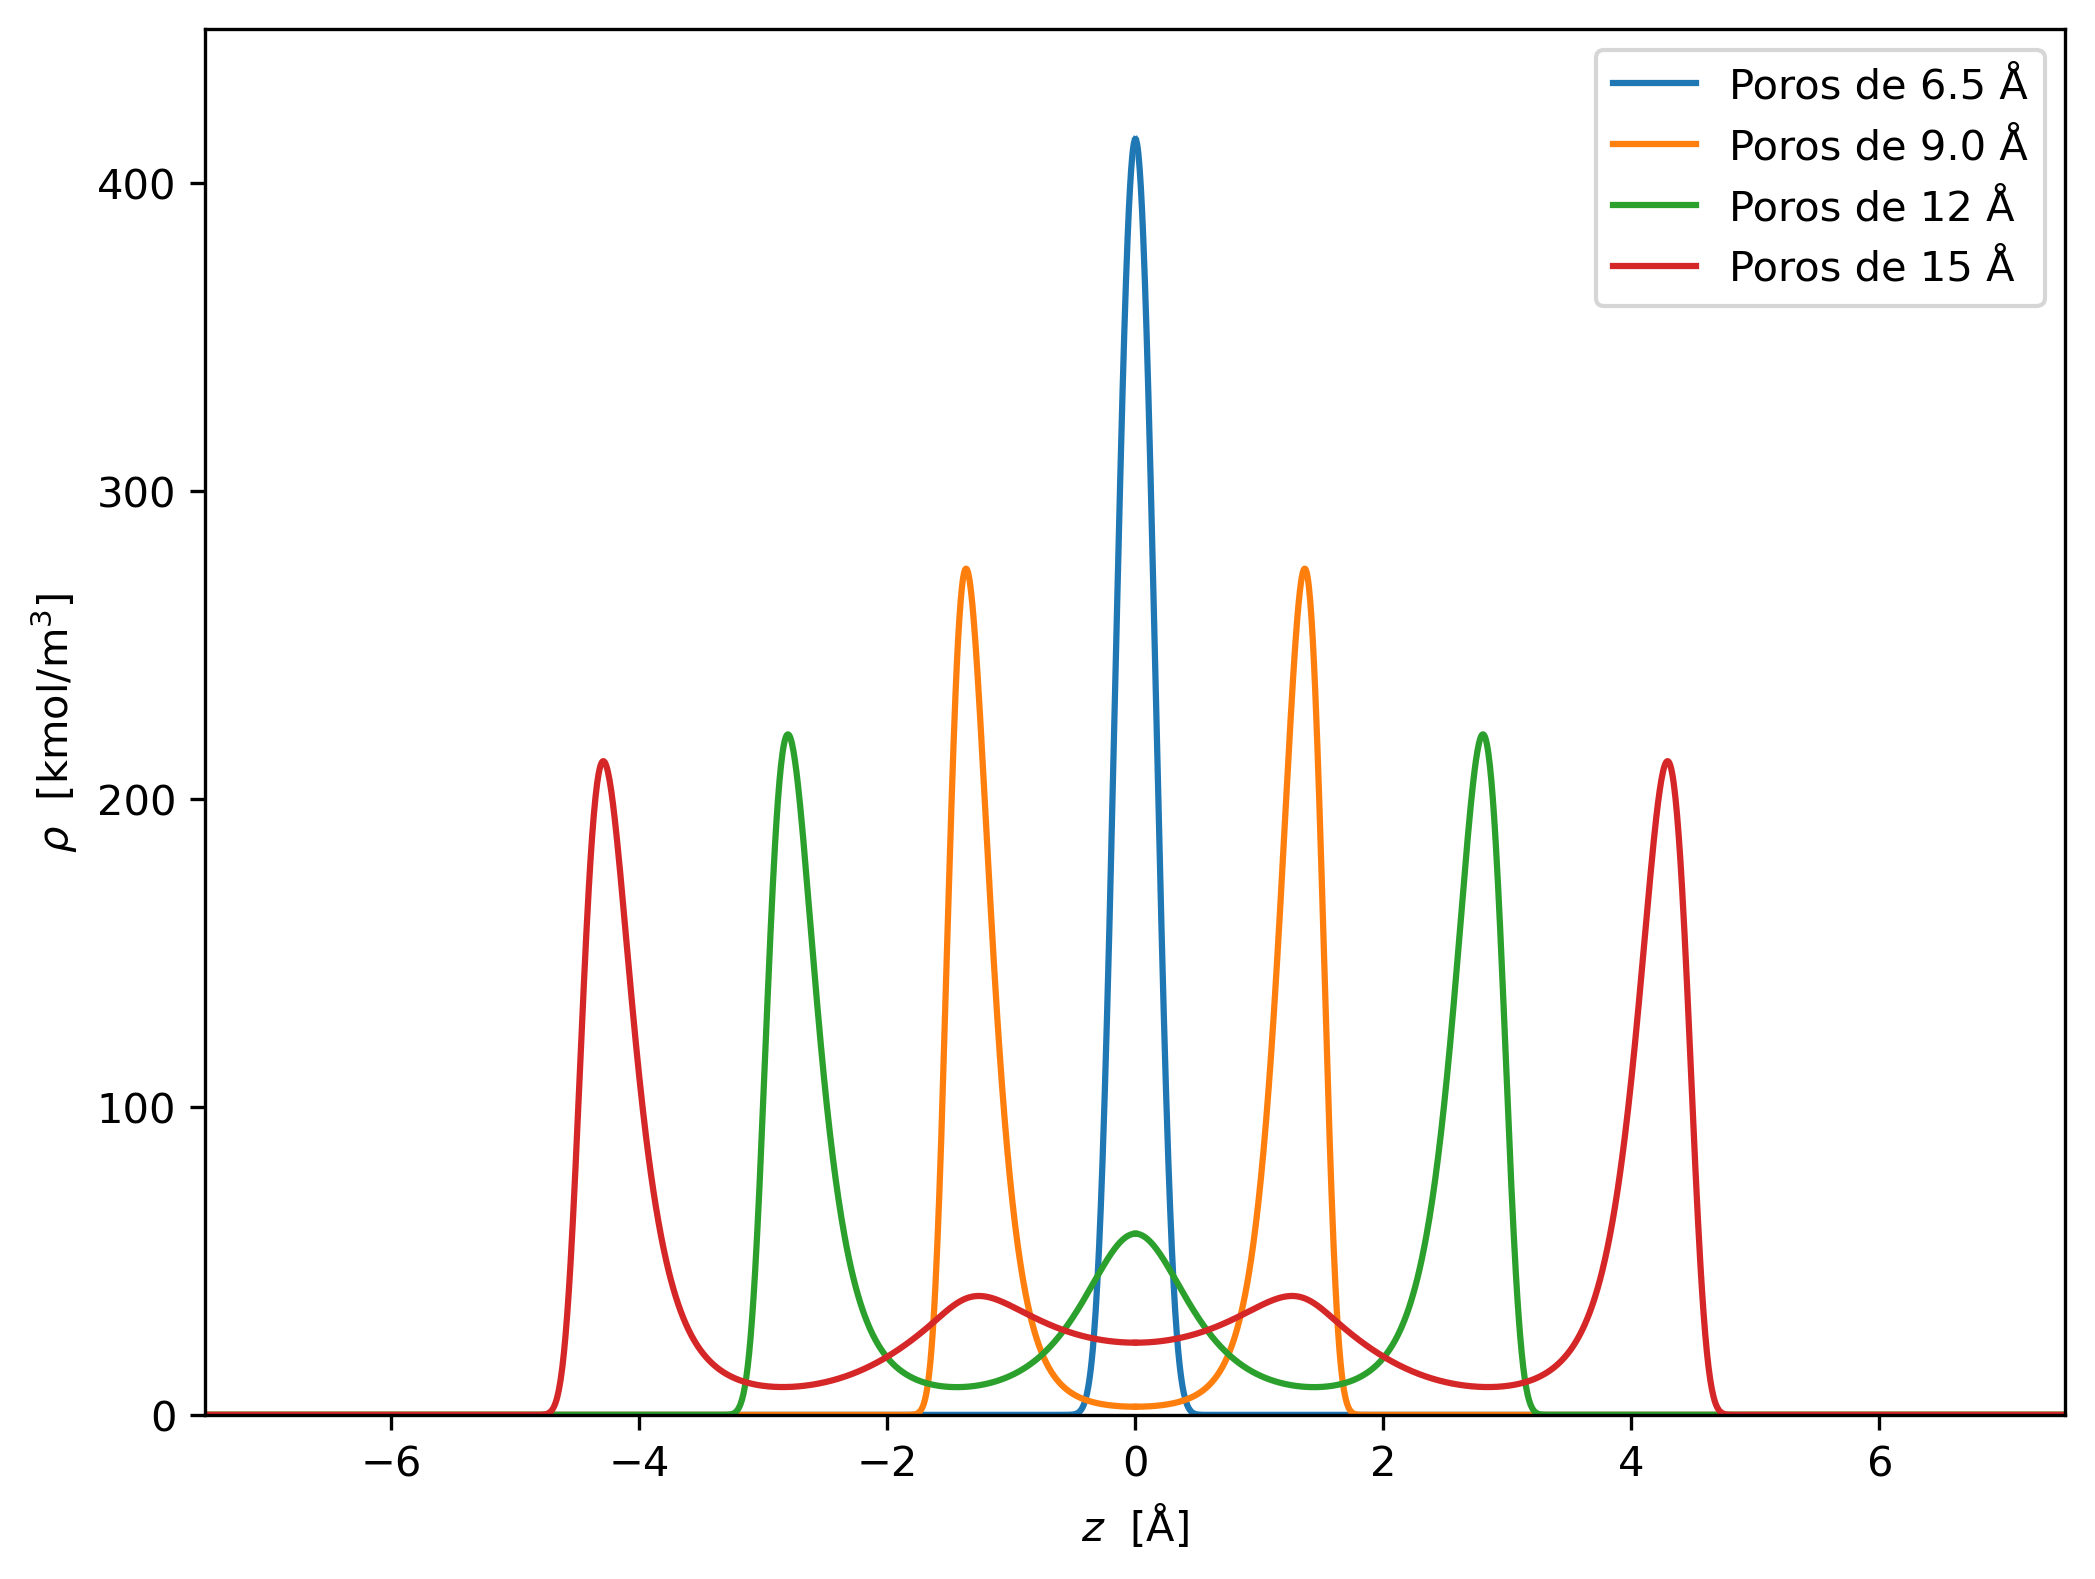

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

temp = 77*KELVIN
pres = 80*BAR

solver = DFTSolver().picard_iteration(tol=1e-5, beta=0.04).anderson_mixing()

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
#potential = ExternalPotential.LJ93(3.844, 37.575, 0.05) # https://doi.org/10.1063/1.5096804

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "mediumpurple"]

for j, i in enumerate([6.5, 9.0, 12, 15]):
    bulk = State(func, temp, pressure=pres)
    porex = Pore1D(Geometry.Cartesian, i*ANGSTROM, potential).initialize(bulk).solve(solver)

    plt.plot(porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000).T, color=colors[j],
         label="Poros de {} Å".format(i))
    plt.plot(-porex.z/(ANGSTROM), (porex.density*(METER**3/MOL)/1000).T, color=colors[j])

plt.legend(loc="best", numpoints=1)  
plt.xlabel(r"$z$  [Å]")
plt.ylabel(r"$\rho$  [kmol/m$^3$]")
plt.xlim(-7.5,7.5)
plt.ylim(-0.1, 450)
#plt.suptitle('Perfiles de densidad para H$_2$ a {} y {}'.format(temp, pres))
plt.show()

Una vez obtenidos y comparados los perfiles de densidad, se determinaron las isotermas de adsorción. Para esto se deben seguir pasos similares a los anteriores, definiendo el tamaño de poro (pore_siz), el potencial del sólido (potential) y  la configuración del poro (pore). Luego se usa "for" para graficar las diferentes isotermas [68,77,100,140,200]. 

"isotherm" utiliza la función `Adsorption1D.adsorption_isotherm` para calcular la isotermas de adsorción en un rango de presiones, esta función requiere que se especifique el funcional a utilizar (func), la temperatura (en el rango for), la presión (que debe ser un vector linspace definido especialmente por $\mathrm{FeO_s}$) y el poro (pore). De esta forma, las soluciones se almacenan en "isotherm".

Luego, para extraer las soluciones de "isotherm" se agrega `.pressure` para obtener la presión (p) y `.total_adsorption` para obtener la cantidad adsorbida (total), para graficar estas magnitudes hay que volverlas adimensionales, por lo que se debe dividir por sus unidades correspondientes.

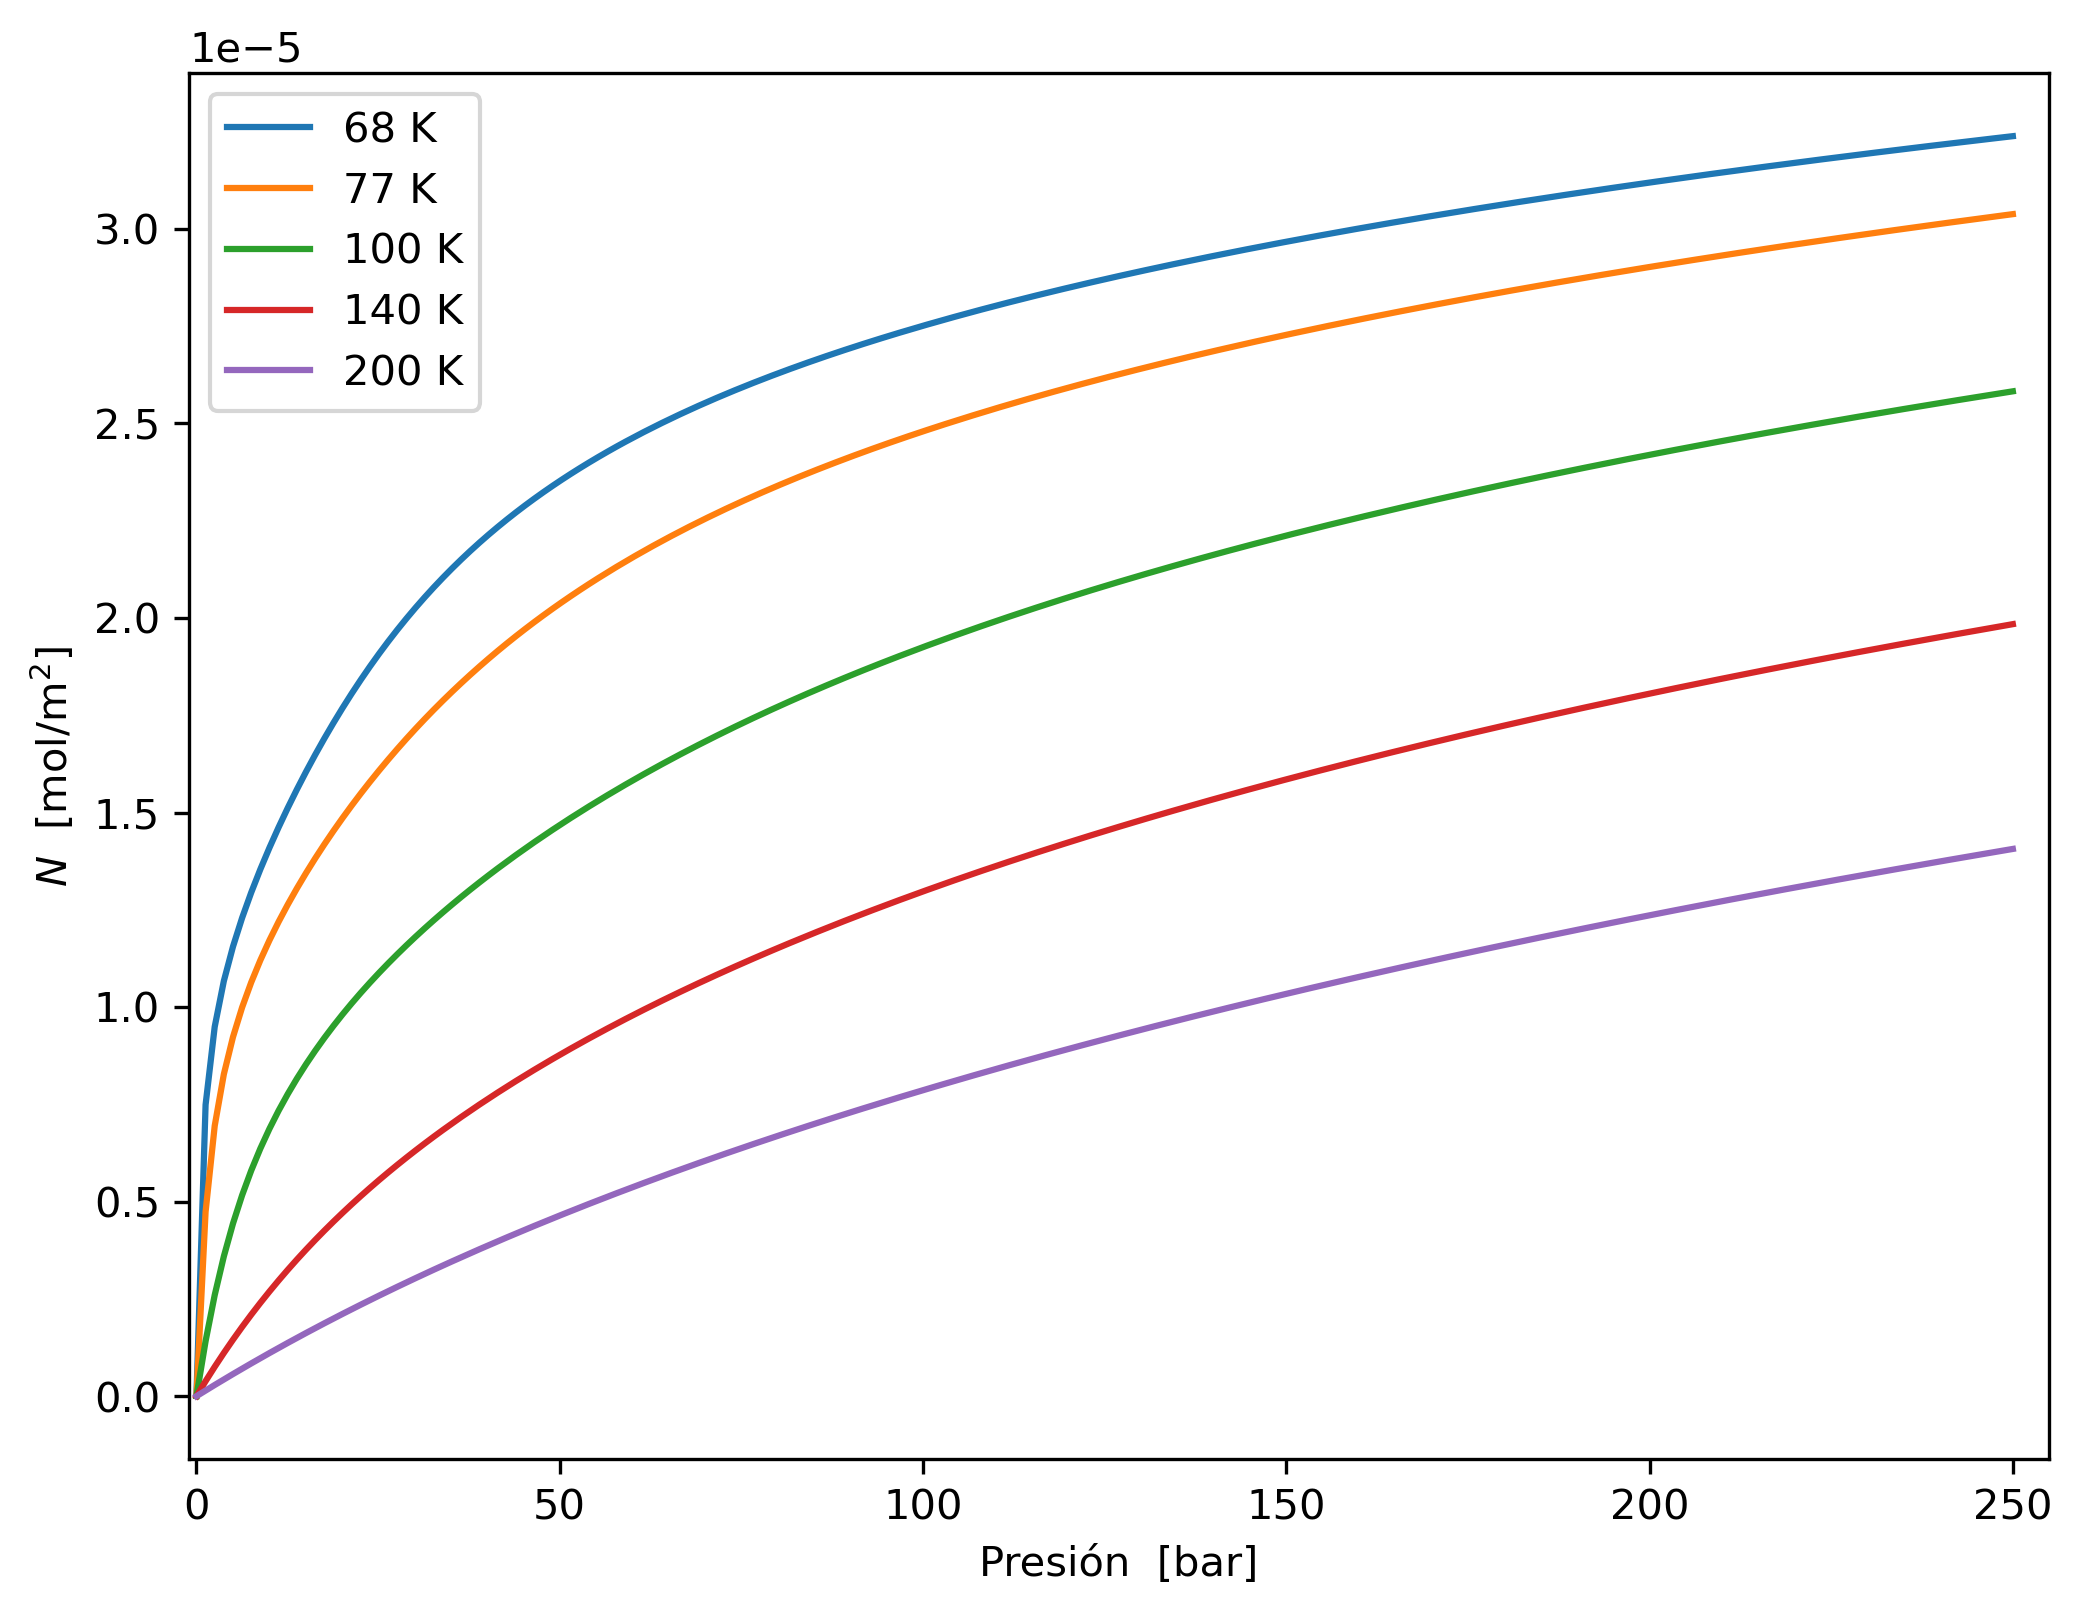

CPU times: user 33.1 s, sys: 426 ms, total: 33.5 s
Wall time: 33.9 s


In [10]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pore_siz = 20 * ANGSTROM

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
#potential = ExternalPotential.LJ93(3.844, 37.575, 0.05) # https://doi.org/10.1063/1.5096804

pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz, potential = potential)

for i in [68,77,100,140,200]:
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (i * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 250*BAR, 200), pore = pore)
    p = isotherm.pressure / BAR
    total = isotherm.total_adsorption / (MOL / METER**2)
    plt.plot(p, total, label="{}".format(i * KELVIN))

plt.legend(loc="best", numpoints=1)    
plt.xlim(-1, 255)
#plt.ylim(-0.1, 40)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[$mol/m$^2]$')
#plt.suptitle('Isotermas de adsorción para H$_2$ en un poro de {}'.format(pore_siz))
plt.show()

A continuación se muestra la comparación realizada con los resultados de <a href = "https://iopscience.iop.org/article/10.1088/0953-8984/14/40/318/pdf"> Levesque $et$ $al.$</a>. Para obtener los valores se utilizó un software de captura de datos y se transformaron las unidades de MPa a Bar. El área especifica (BET) está en $m^2/g$.

In [11]:
BET=1800   

Levesque_p150=[0.09, 0.48, 1.0, 2.99, 5.0, 9.99, 14.99, 20.0]
Levesque_a150=[2.0, 7.33, 12.83, 23.42, 28.42, 35.75, 39.17, 41.42]
Levesque_P150=np.multiply(Levesque_p150,10)

Levesque_p293=[0.09, 0.5, 1.02, 3.01, 5, 10.01, 14.99, 19.98]
Levesque_a293=[0.17, 0.83, 1.67, 4.5, 6.83, 11.58, 15.42, 19.42]
Levesque_P293=np.multiply(Levesque_p293,10)

En este gráfico se sigue el mismo procedimiento del caso anterior cuidando de utilizar las mismas condiciones reportadas por Levesque $et$ $al.$ y transformando las unidades a $g_{H_2}/kg_{c}$ En este caso, la comparación se hace a dos temperaturas diferentes.

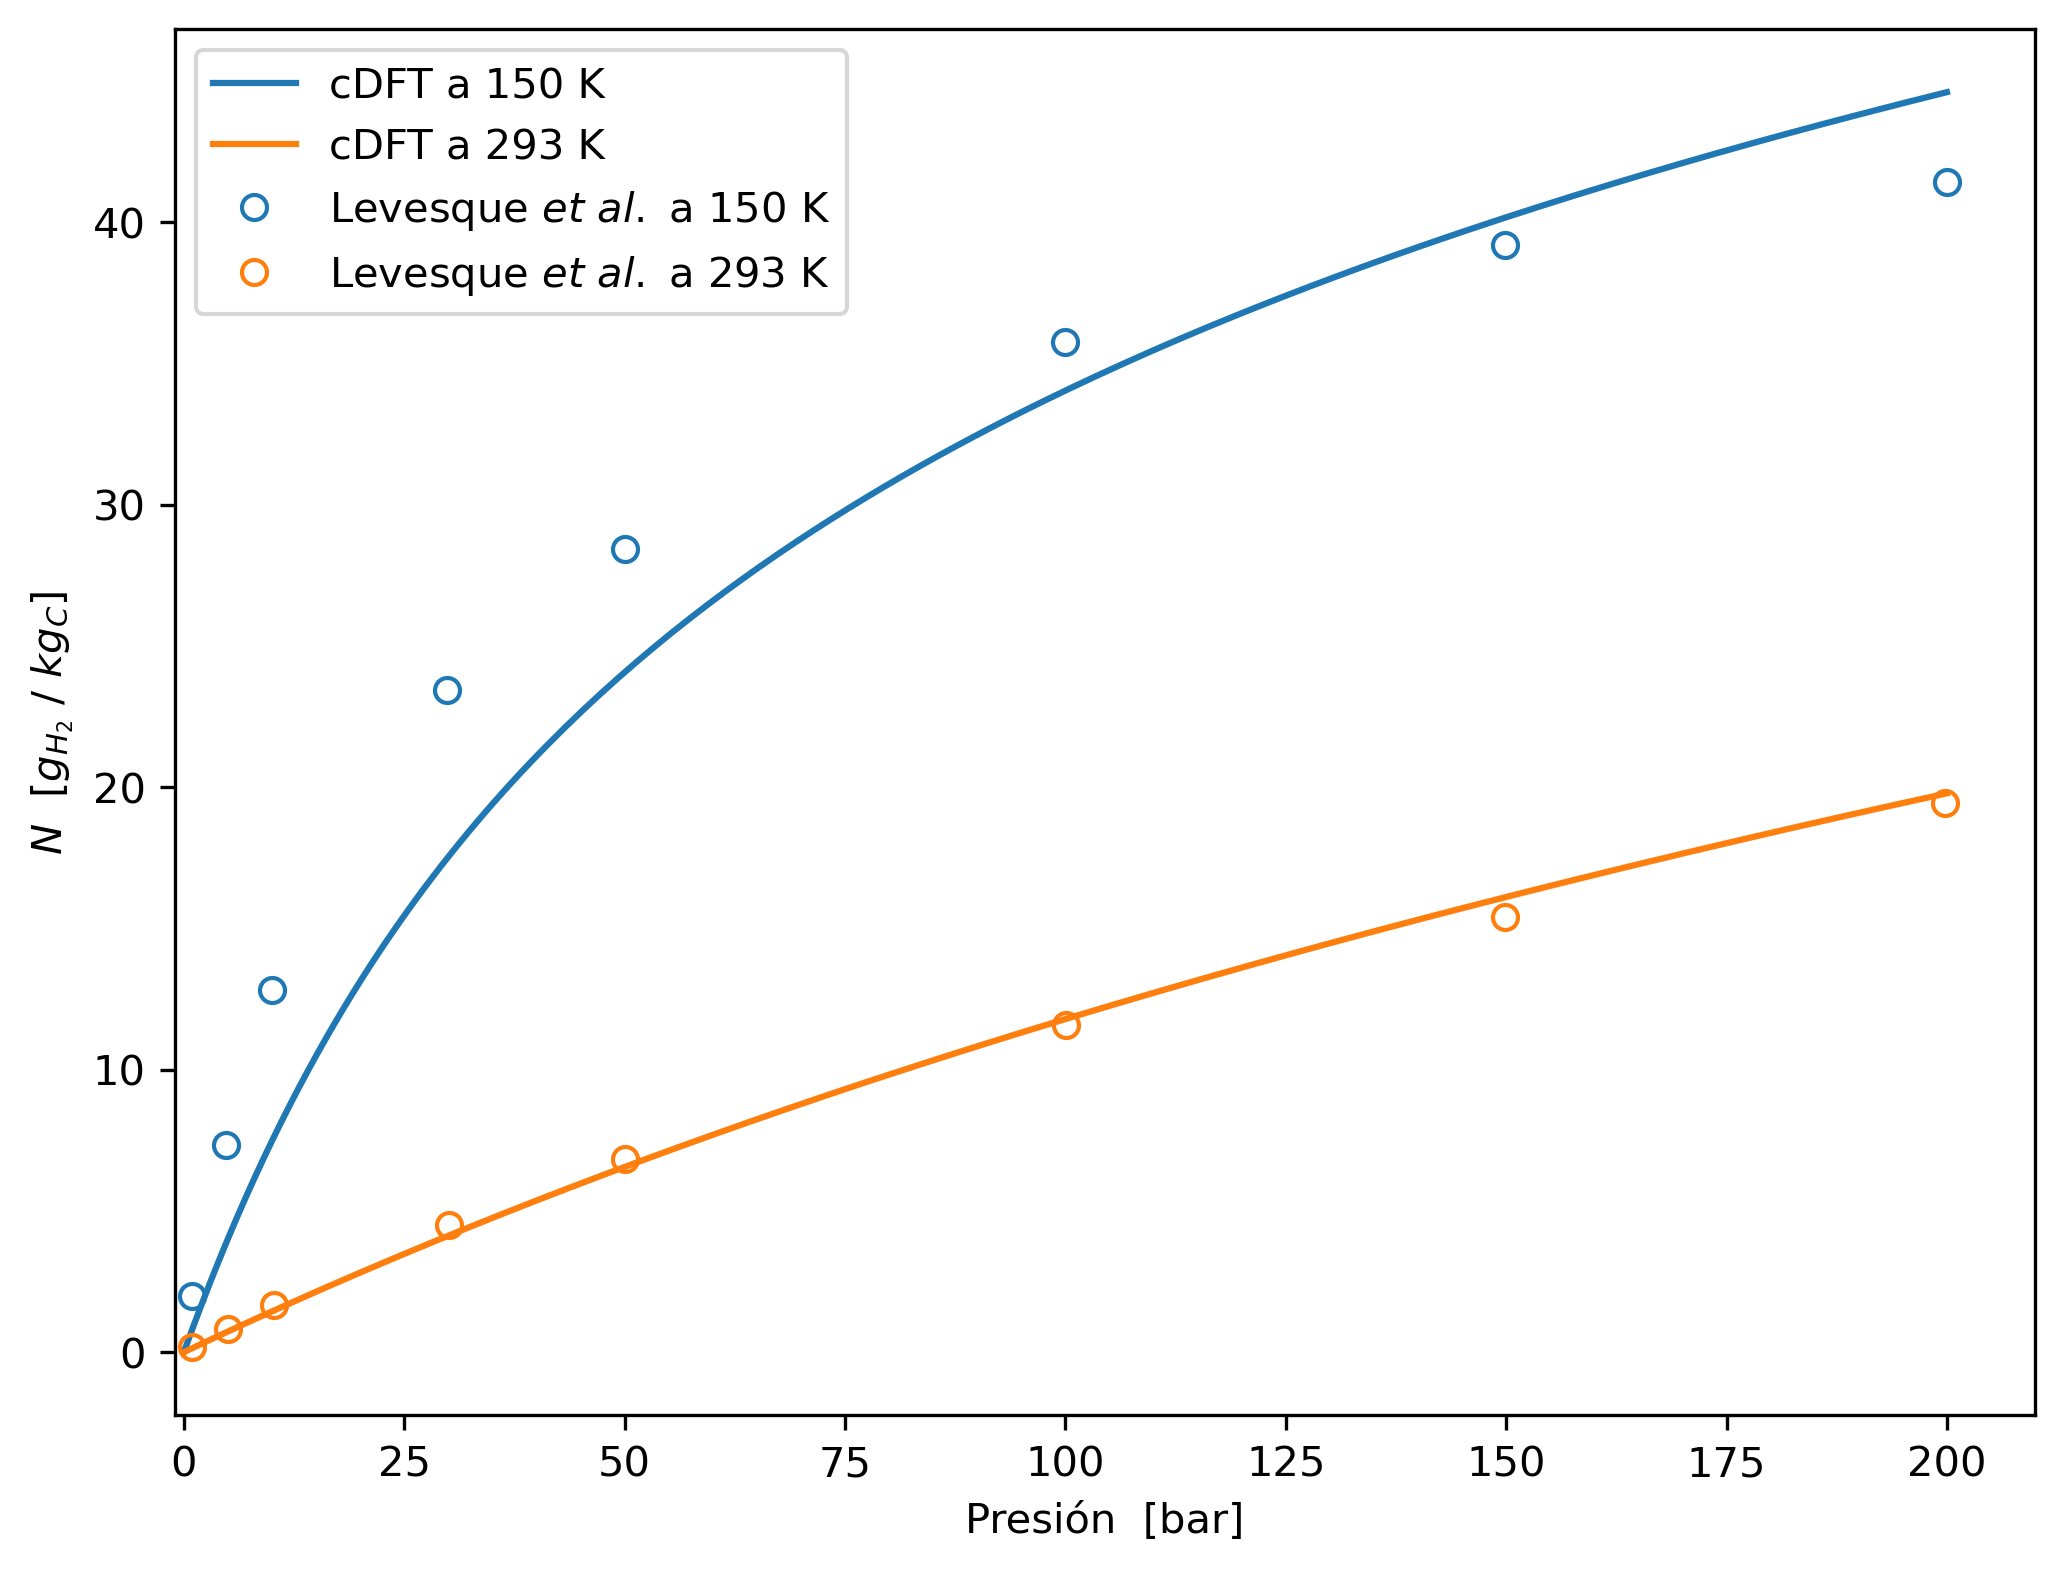

CPU times: user 10.8 s, sys: 100 ms, total: 10.9 s
Wall time: 11.1 s


In [12]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pore_siz = 13.3  * ANGSTROM

potential = ExternalPotential.Steele(3.40, 28.0, 0.114)  # https://doi.org/10.1021/la803666t
#potential = ExternalPotential.LJ93(3.844, 37.575, 0.05) # https://doi.org/10.1063/1.5096804

pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz, potential = potential)

for i in [150, 293]:
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (i * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 200*BAR, 200), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MICRO * MOL / METER**2)
    plt.plot(p, (total_adsorption/1000)*BET*2.016, label="cDFT a {}".format(i * KELVIN))

plt.plot(Levesque_P150, Levesque_a150, label="Levesque $et$ $al.$ a 150 K", color="tab:blue", marker="o", linestyle="None", mfc="None")
plt.plot(Levesque_P293, Levesque_a293, label="Levesque $et$ $al.$ a 293 K", color="tab:orange", marker="o", linestyle="None", mfc="None")

plt.legend(loc="best", numpoints=1)    
plt.xlim(-1, 210)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[g_{H_2}$ / $kg_{C}]$')
#plt.suptitle('Isotermas de adsorción para H2 en un poro de {}'.format(pore_siz))
plt.show()

El mismo procedimiento anterior se realiza para comparar los resultados de <a href = "https://doi.org/10.3390/reactions2030014"> Khozina $et$ $al.$</a>. Para obtener los valores se utilizó un software de captura de datos y se transformaron las unidades de MPa a Bar y de mmol/g a mol/g. El área especifica (BET) está en $m^2/g$.

In [13]:
BET=2760

Khozina_pACS= [0.53, 0.93, 1.32, 2.49, 3.64, 4.81, 5.96, 7.15, 8.33, 9.5, 10.77, 11.87, 13.13, 14.21, 15.69] #MPa
Khozina_aACS= [0.54, 0.92, 1.18, 2.23, 3.2, 4.06, 4.95, 5.76, 6.57, 7.35, 8.19, 8.91, 9.69, 10.28, 11.09] #mmol/g

Khozina_PACS= np.multiply(Khozina_pACS,10)     # Bar
Khozina_AACS=np.divide(Khozina_aACS,1000)      # mol/g

En este gráfico se sigue el mismo procedimiento del caso anterior cuidando de utilizar las mismas condiciones reportadas por Khozina $et$ $al.$, en este caso, la comparación se hace a dos valores diferentes de $\varepsilon_{ss}/k_B$.

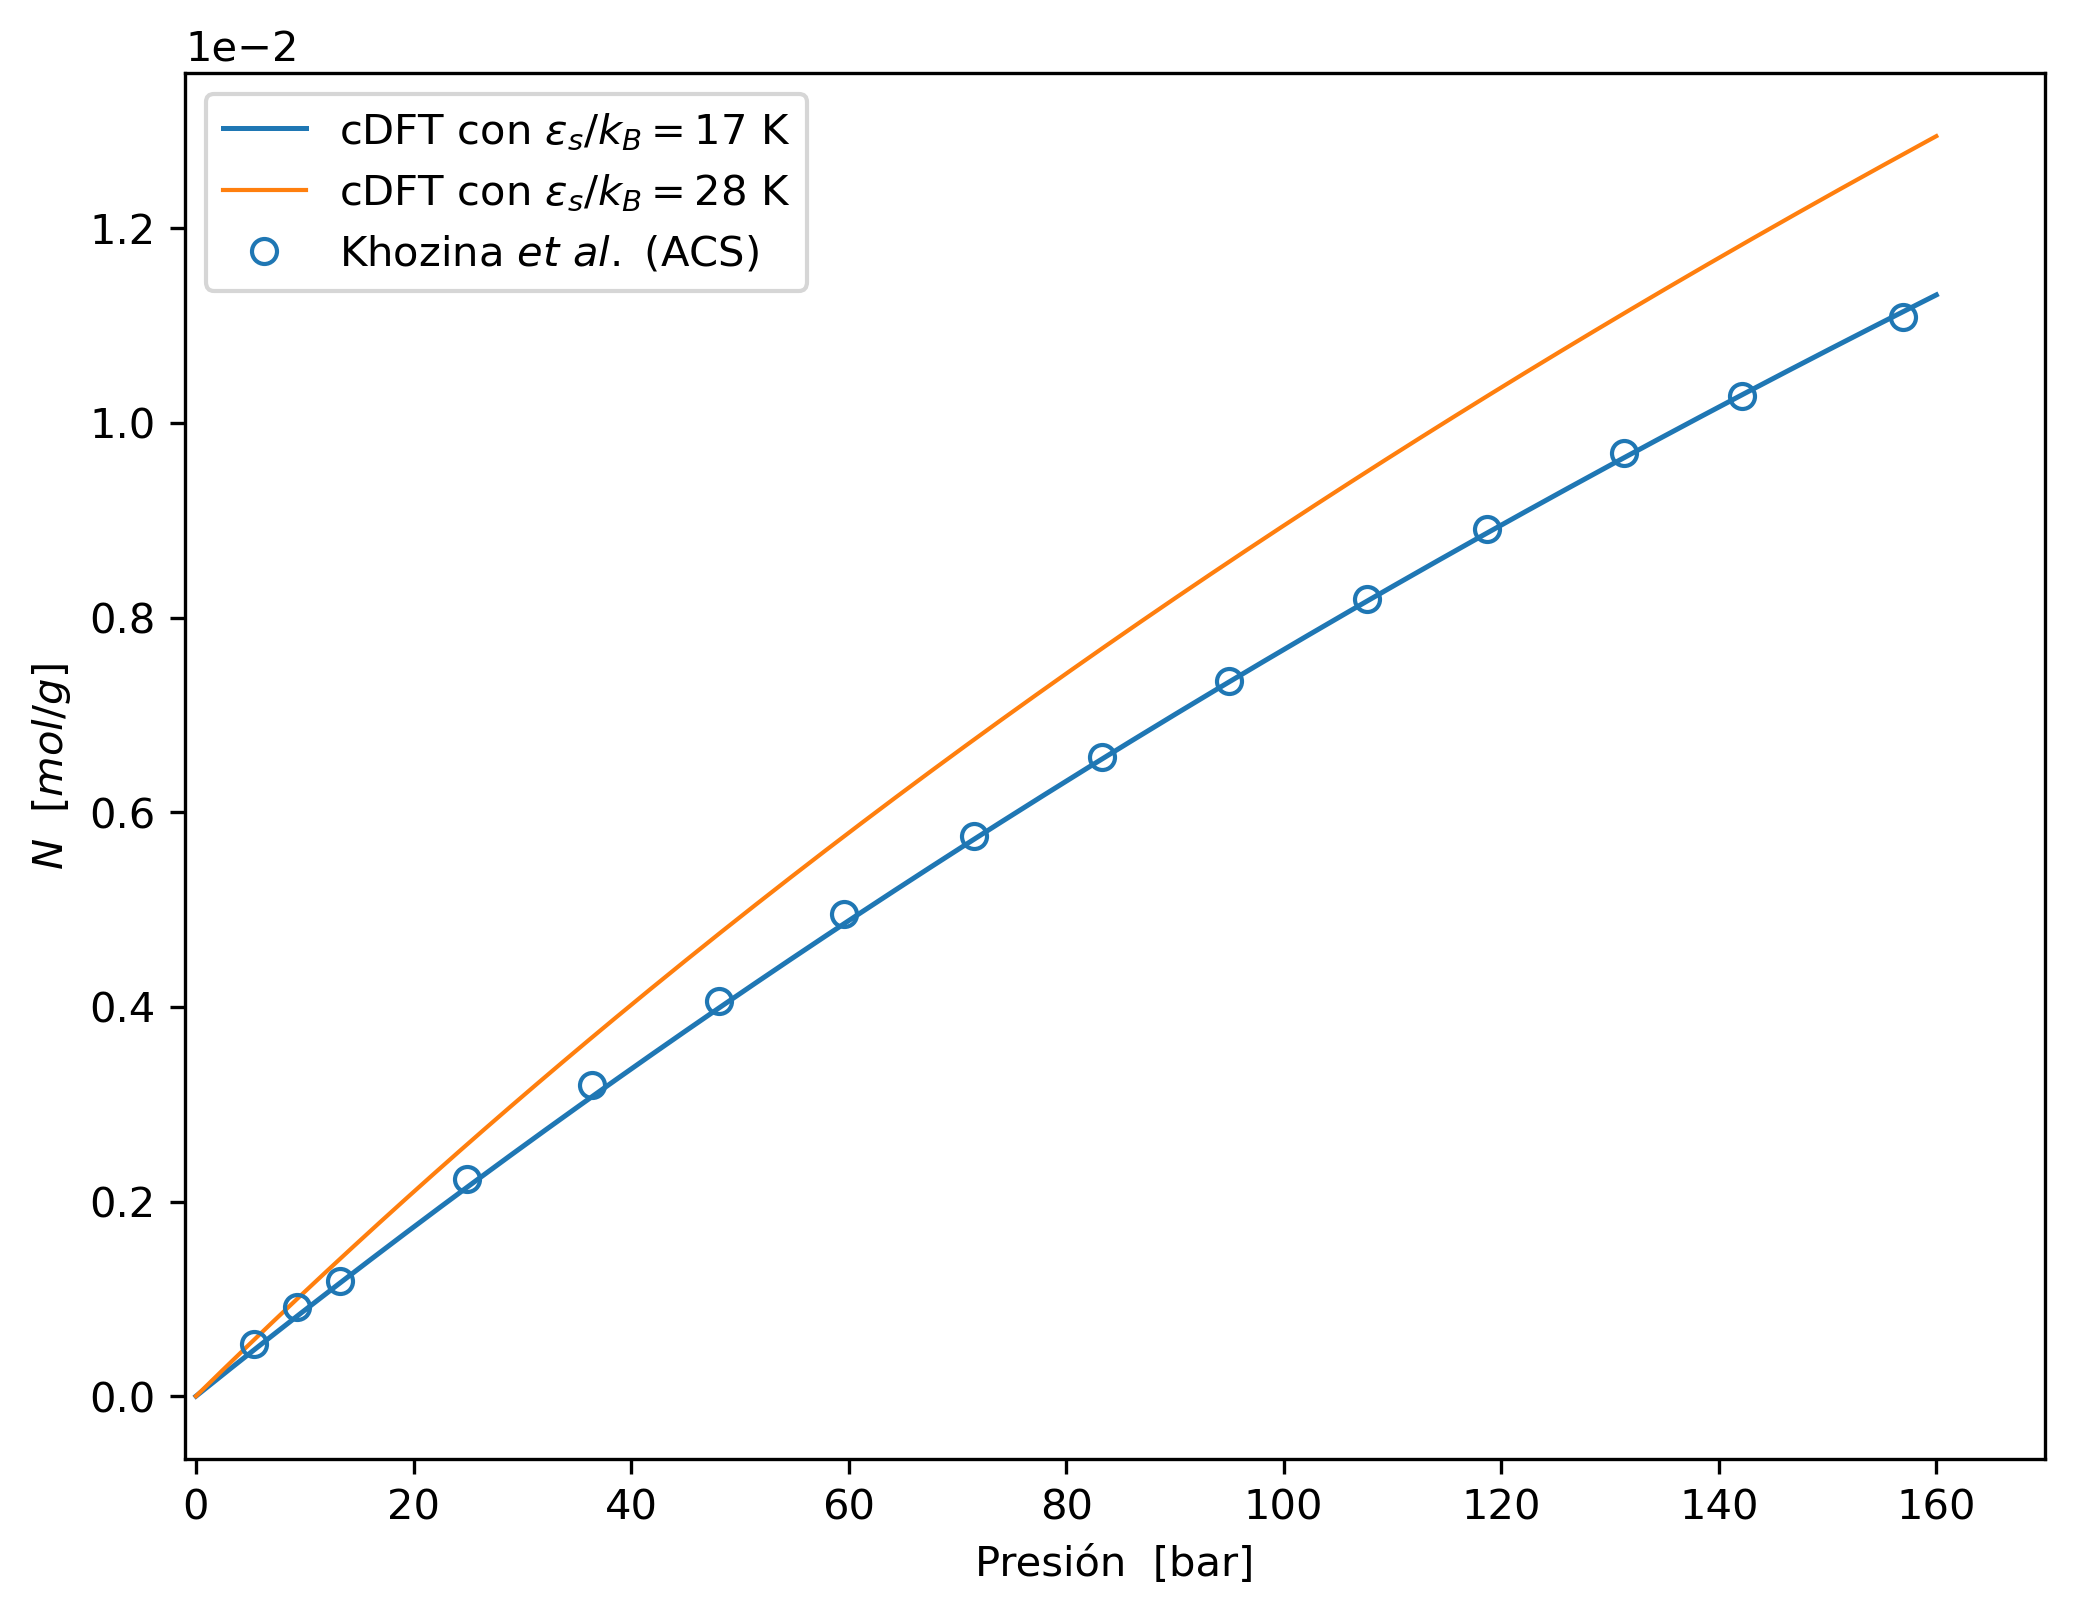

CPU times: user 9.74 s, sys: 220 ms, total: 9.96 s
Wall time: 10.2 s


In [14]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

colors1 = ["tab:blue", "tab:orange"]
line=["-","-"]
width=[1.2,1.0]
naux1 = 0

for i in [17, 28]:
    potential = ExternalPotential.Steele(3.40, i, 0.114)  # https://doi.org/10.1021/la803666t
    pore = Pore1D(geometry=Geometry.Cartesian, pore_size = 14.2 * ANGSTROM, potential = potential)
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (303 * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 160*BAR, 200), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MOL / METER**2)

    plt.plot(p, total_adsorption*BET, label=r"cDFT con $\varepsilon_s / k_B = {}$ K".format(i),
                 color = colors1[naux1], linestyle=line[naux1], linewidth=width[naux1])
    naux1+=1

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(Khozina_PACS,Khozina_AACS, label="Khozina $et$ $al.$ (ACS)", marker="o", linestyle="None", mfc="None")

plt.legend(loc="best", numpoints=1)    
plt.xlim(-1, 170)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[mol/g]$')
#plt.suptitle('Comparación con resultados experimentales a 303 K')
plt.show()

El mismo procedimiento anterior se realiza para comparar los resultados de otro sólido reportado por <a href = "https://doi.org/10.3390/reactions2030014"> Khozina $et$ $al.$</a>.

In [15]:
BET=1830
Khozina_pFAC3= [2.15, 3.85, 5.6, 7.32, 9.16, 10.89, 12.7, 14.21, 16.2]  # MPa
Khozina_aFAC3= [1.42, 2.4, 3.14, 4.03, 4.73, 5.43, 6.1, 6.61, 7.2]      #mmol/g

Khozina_PFAC3= np.multiply(Khozina_pFAC3,10)     # Bar
Khozina_AFAC3=np.divide(Khozina_aFAC3,1000)      # mol/g

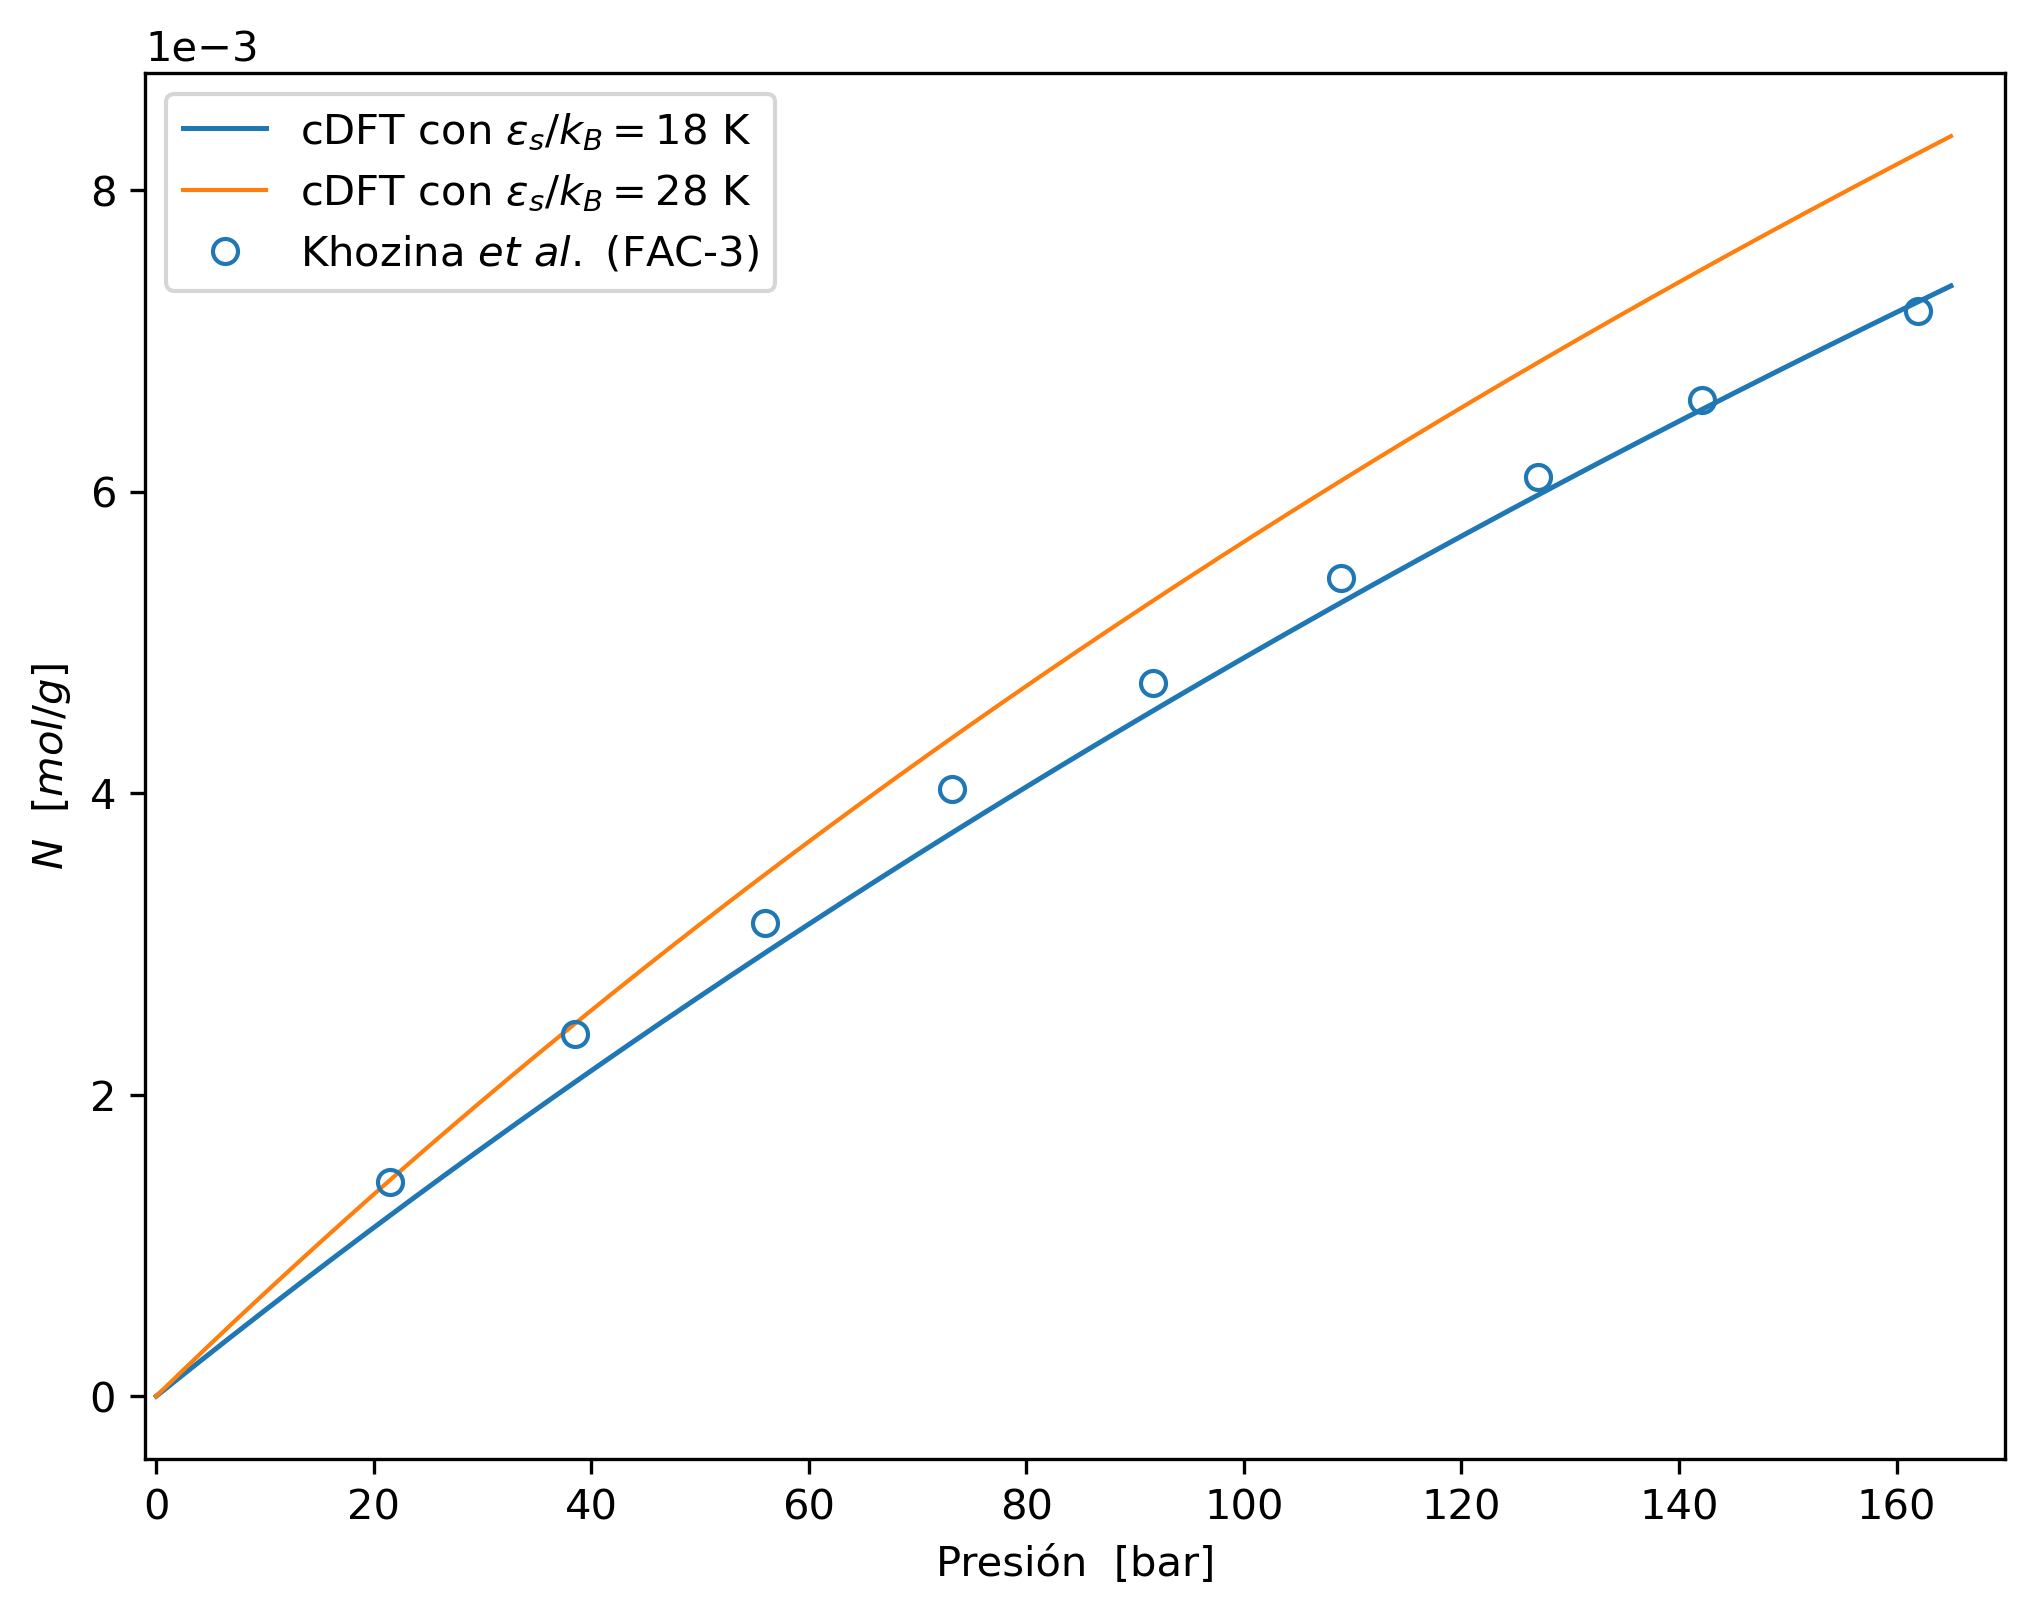

CPU times: user 9.37 s, sys: 116 ms, total: 9.49 s
Wall time: 9.56 s


In [16]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

colors2 = ["tab:blue", "tab:orange"]
line=["-","-"]
width=[1.2,1.0]
naux2 = 0

for i in [18,28]:
    potential = ExternalPotential.Steele(3.40, i, 0.114)  # https://doi.org/10.1021/la803666t
    pore = Pore1D(geometry=Geometry.Cartesian, pore_size = 13.4 * ANGSTROM, potential = potential)
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (303 * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 165*BAR, 200), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MOL / METER**2)

    plt.plot(p, (total_adsorption/1)*BET, label=r"cDFT con $\varepsilon_s / k_B = {}$ K".format(i),
                 color = colors2[naux2], linestyle=line[naux2], linewidth=width[naux2])
    naux2+=1

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(Khozina_PFAC3,Khozina_AFAC3, label="Khozina $et$ $al.$ (FAC-3)", marker="o", linestyle="None", mfc="None")

plt.legend(loc="best", numpoints=1)    
plt.xlim(-1, 170)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[mol/g]$')
#plt.suptitle('Comparación con resultados experimentales a 303 K')
plt.show()

El mismo procedimiento anterior se realiza para comparar los resultados de <a href = "https://pubs.acs.org/doi/10.1021/la900220g"> Bhatia $et$ $al.$</a>. Para obtener los valores se utilizó un software de captura de datos y se transformaron las unidades de atm a Bar y de mmol/m² a mol/m².

In [17]:
Bhatia_p=[0.01412, 0.07464, 0.09712, 0.1464, 0.19914, 0.24841, 0.29683, 0.34957, 0.39539, 0.45159, 0.49395, 
      0.55014, 0.59942, 0.6487, 0.70144, 0.74986, 0.79914, 0.85187, 0.90548, 0.95043]              # atm
Bhatia_a= [0.000281, 0.000893, 0.0011, 0.001524, 0.001947, 0.002263, 0.002607, 0.002923, 0.003277, 0.003523, 0.00377,
       0.003986, 0.004222, 0.004439, 0.004655, 0.004822, 0.005098, 0.005285, 0.005491, 0.005629]   # mmol/m²
Bhatia_P= np.multiply(Bhatia_p,1.01325)   # Bar
Bhatia_A= np.multiply(Bhatia_a,1/1000)    # mol/m²

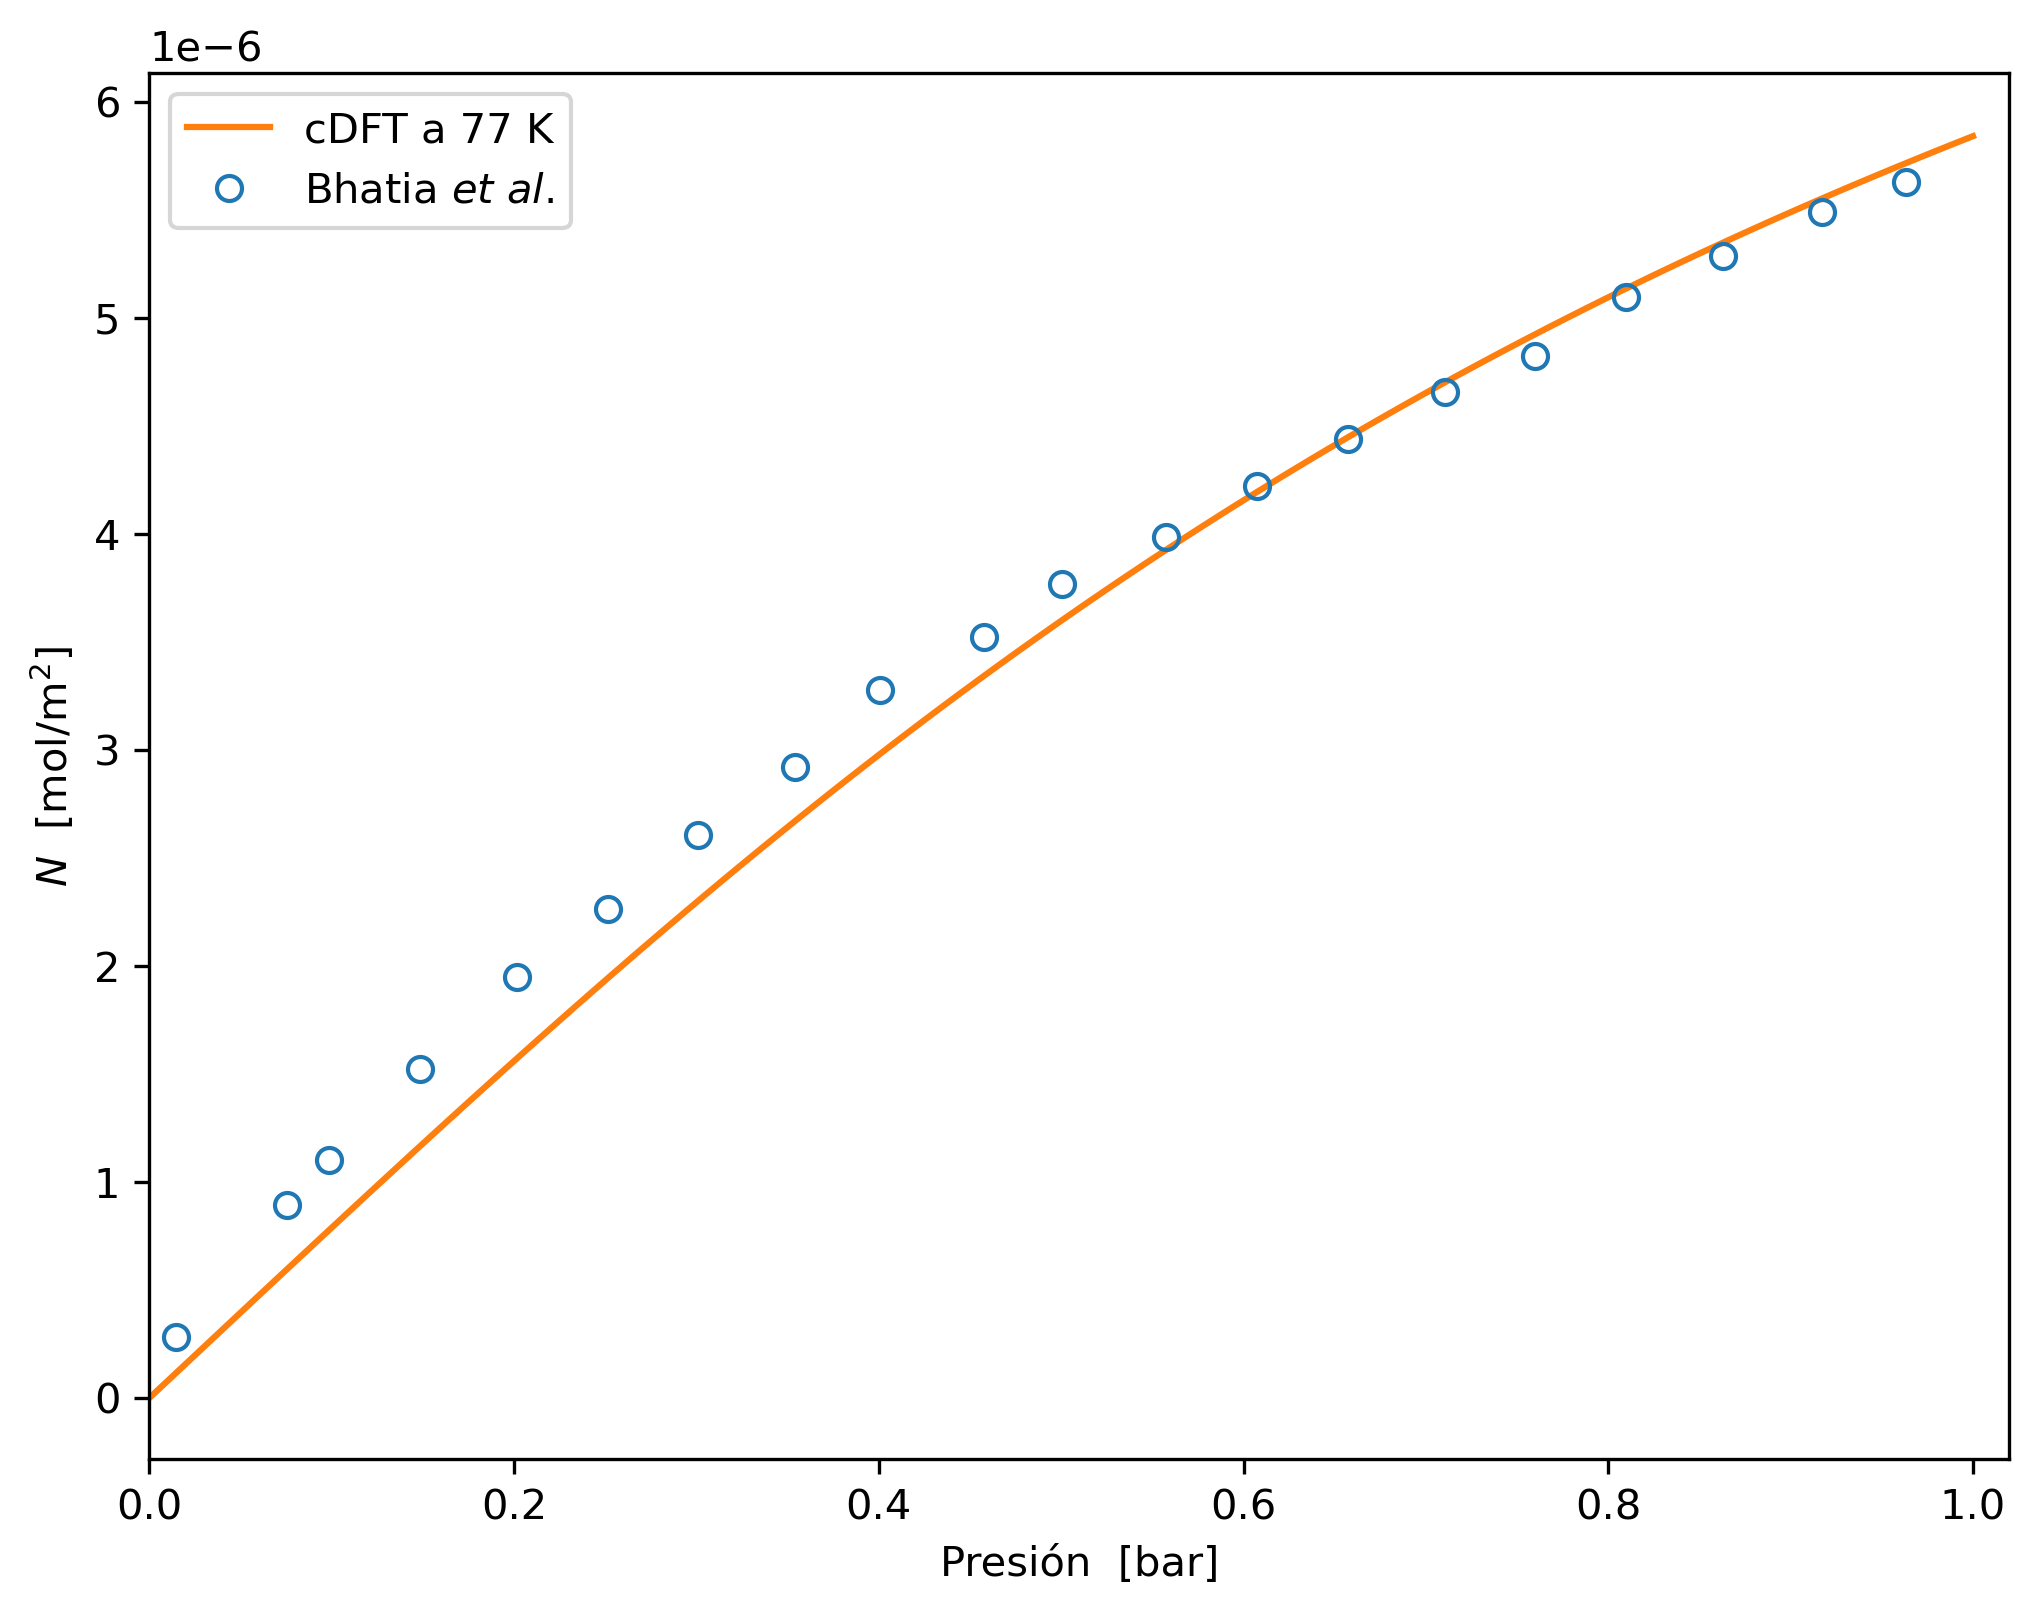

CPU times: user 2.29 s, sys: 102 ms, total: 2.39 s
Wall time: 2.4 s


In [18]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pore_siz = 11 * ANGSTROM

potential = ExternalPotential.Steele(3.40, 28, 0.114)  # https://doi.org/10.1021/la803666t

pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz, potential = potential)

for i in [77]:
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (i * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 1*BAR, 100), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MOL / METER**2)
    
    plt.plot(p, total_adsorption, color="tab:orange", label="cDFT a 77 K")
    
plt.plot(Bhatia_P,Bhatia_A, label="Bhatia $et$ $al.$", color="tab:blue", marker="o", linestyle="None", mfc="None")
plt.legend(loc="best", numpoints=1)    
plt.xlim(0, 1.02)
#plt.ylim(-0.1, 6.5)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[$mol/m$^2]$')
#plt.suptitle('Comparación con resultados experimentales a 77 K')
plt.show()

El mismo procedimiento anterior se realiza para comparar los resultados de <a href = "https://aip.scitation.org/doi/10.1063/1.478114"> Wang y Johnson</a>. Para obtener los valores se utilizó un software de captura de datos y se transformaron las unidades de atm a Bar.

In [19]:
BET=2600

WJ_p20= [5.231, 12.072, 19.92, 25.755, 32.998, 49.698, 59.96, 79.879, 99.799]                     # atm
WJ_a20= [47.559, 66.142, 77.165, 84.409, 91.024, 103.937, 111.811, 123.094, 129.764]              # g/kg
WJ_P20= np.multiply(WJ_p20,1.01325)                                                               # bar

WJ_p12= [2.012, 19.92, 49.899, 59.96, 79.879, 100.0]                                              # atm
WJ_a12= [35.591, 71.496, 83.465, 84.724, 87.504, 90.283]                                          # g/kg
WJ_P12= np.multiply(WJ_p12,1.01325)                                                               # bar
         
WJ_p6= [0.604, 5.03, 12.072, 19.919, 25.956, 32.998, 49.899, 59.96, 79.879, 100]                  # atm
WJ_a6= [28.032, 31.181, 33.386, 34.646, 34.961, 34.961, 34.961, 35.906, 35.906, 36.221]           # g/kg
WJ_P6= np.multiply(WJ_p6,1.01325)                                                                 # bar

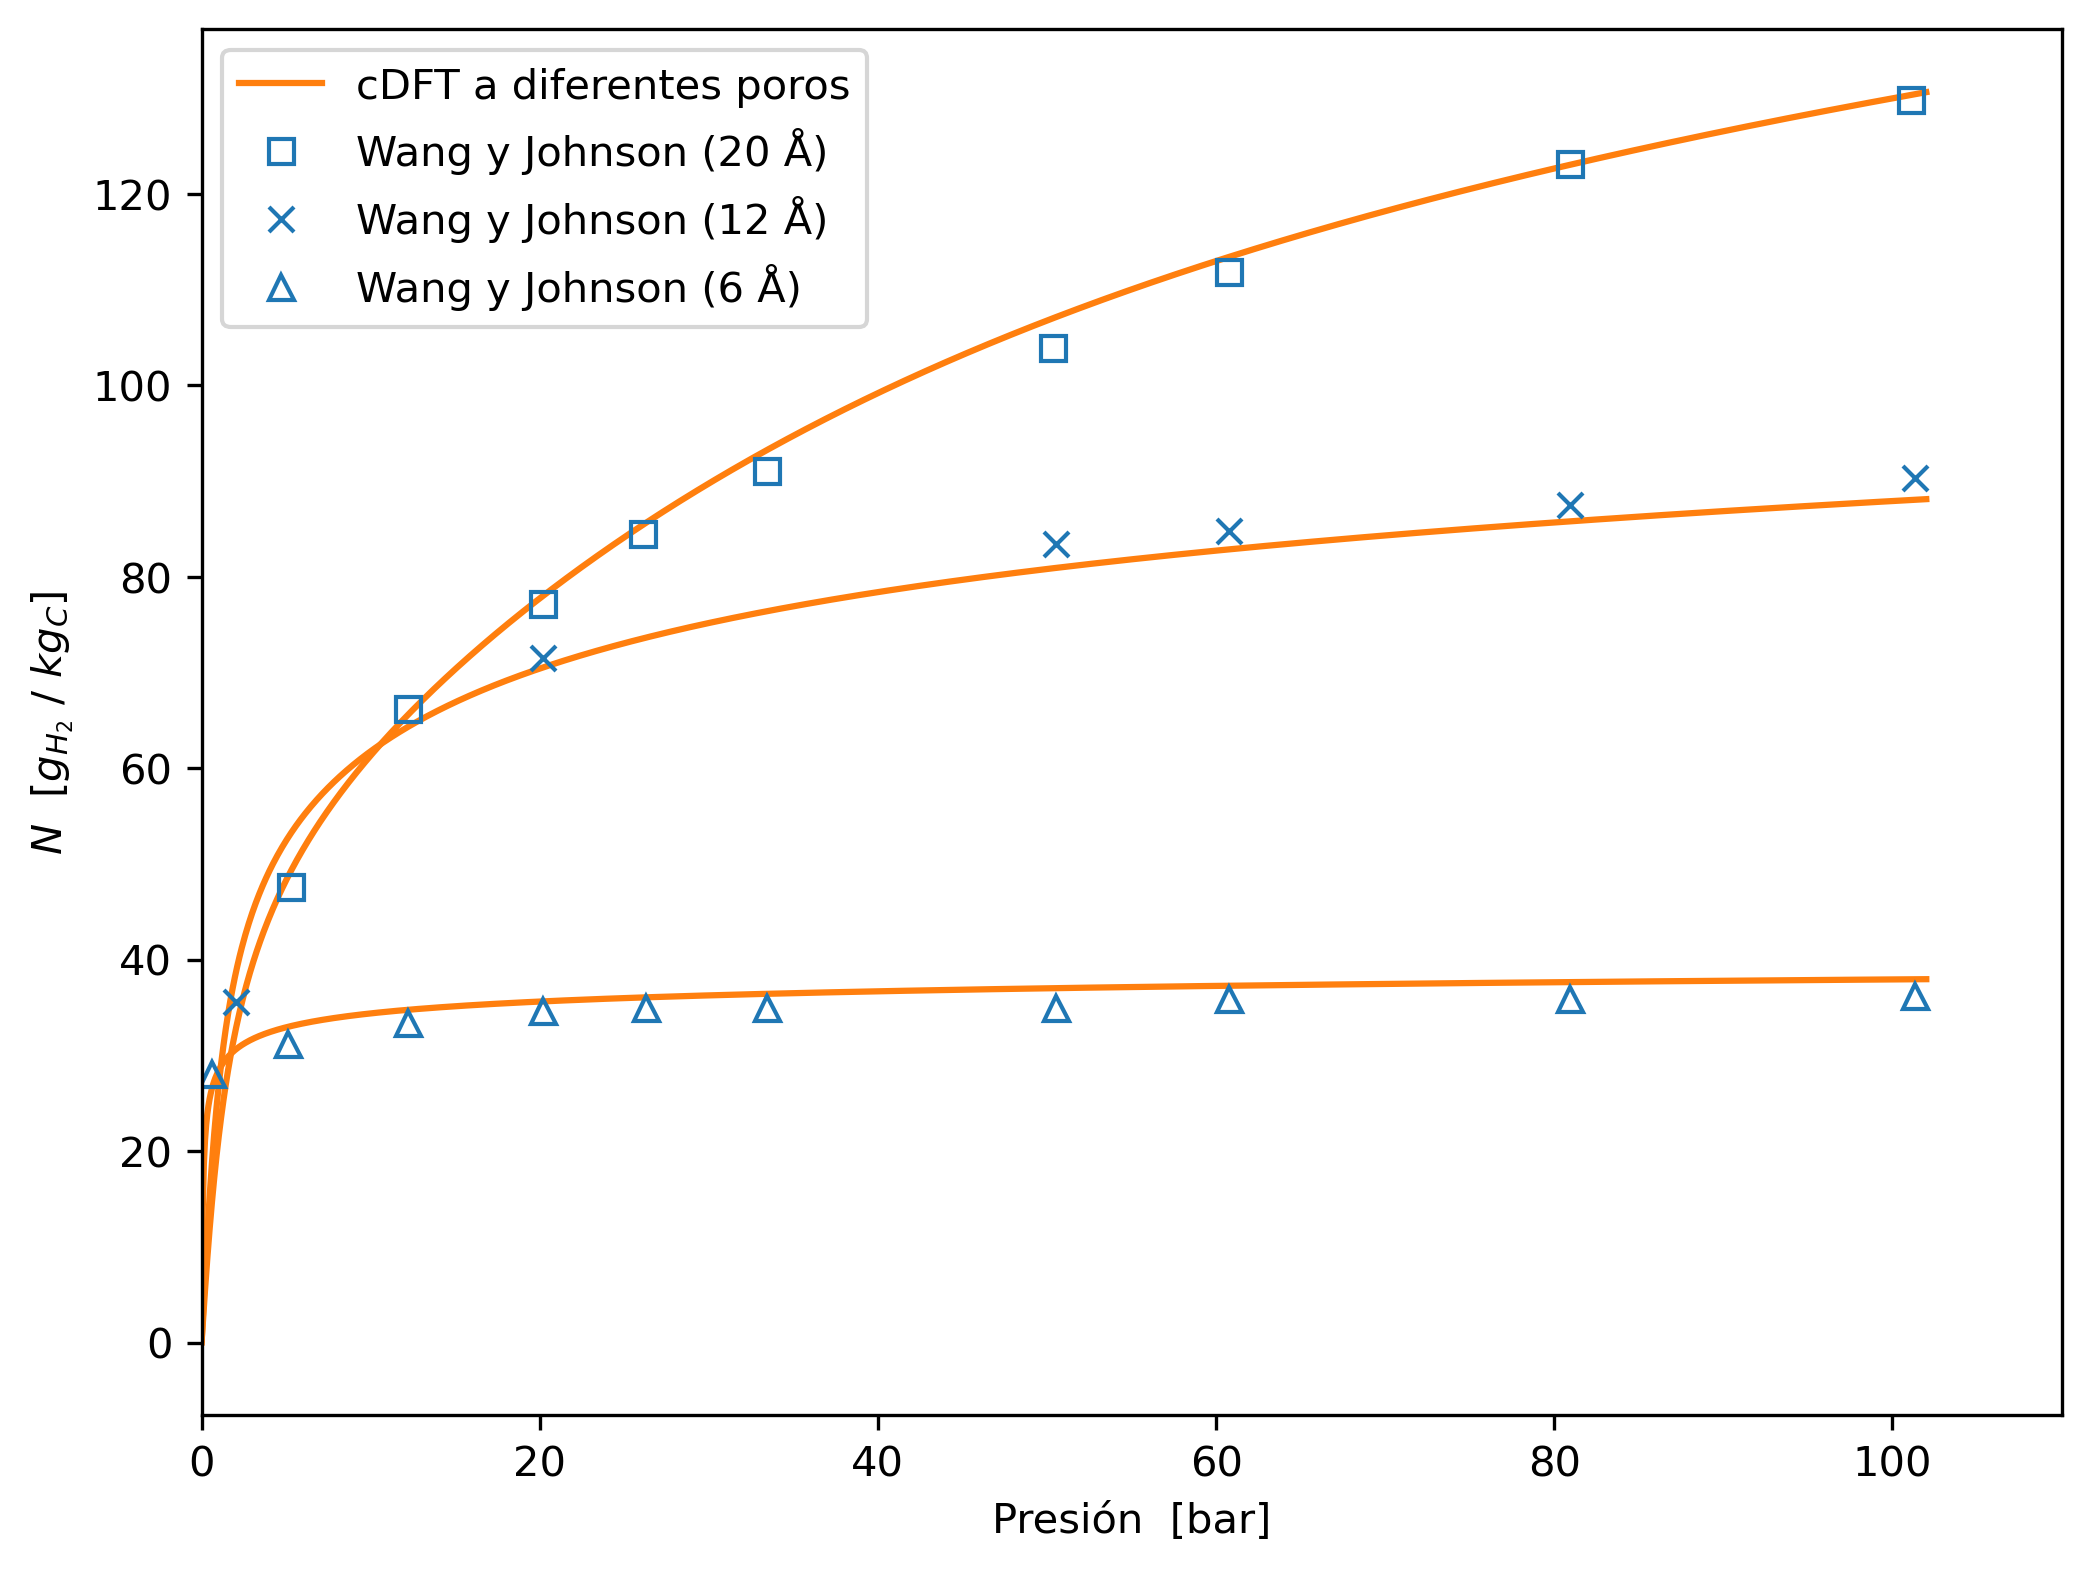

CPU times: user 1min 54s, sys: 955 ms, total: 1min 55s
Wall time: 1min 56s


In [20]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pore_siz = 20 * ANGSTROM

potential = ExternalPotential.Steele(3.40, 28, 0.114)  # https://doi.org/10.1021/la803666t

for i in [6,12,20]:
    pore = Pore1D(geometry=Geometry.Cartesian, pore_size = i * ANGSTROM, potential = potential)
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (77 * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 102*BAR, 1500), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MOL / METER**2)
    
    plt.plot(p, total_adsorption*BET*2.016*1000, color="tab:orange")

plt.plot(-1,-1, label="cDFT a diferentes poros", color="tab:orange")
plt.plot(WJ_P20, WJ_a20, label="Wang y Johnson (20 Å)", color="tab:blue", marker="s", linestyle="None", mfc="None")
plt.plot(WJ_P12, WJ_a12, label="Wang y Johnson (12 Å)", color="tab:blue", marker="x", linestyle="None", mfc="None")
plt.plot(WJ_P6, WJ_a6, label="Wang y Johnson (6 Å)", color="tab:blue", marker="^", linestyle="None", mfc="None")

plt.legend(loc="best", numpoints=1)    
plt.xlim(0, 110)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'$N$  $[g_{H_2}$ / $kg_{C}]$')
#plt.suptitle('Comparación con resultados a 77 K')
plt.show()

Finalmente, se muestran los resultados del modelo que ajusta los resultados experimentales realizados en el Departamento de Ingeniería Química de la Universidad de Concepción. Primero se importan los resultados en formato csv.

In [21]:
# Importar datos experimentales
import csv
import pandas as pd

df_9 = pd.read_csv('./009.csv',header= None)

RelPr_9 = df_9[0] # Presion relativa
AbsPr_9 = df_9[1] # Presion absoluta en mmHg
Qadso_9 = df_9[2] # Cantidad adsorbida en cm3/g STP
Weight_9= df_9[3] # Cantidad adsorbida en g H2/ 100 g adsorbente
AbsP2_9 = AbsPr_9*0.00133322 # Presion absoluta en bar
#df.head()

Luego, se ajusta el modelo para reproducir los resultados experimentales.

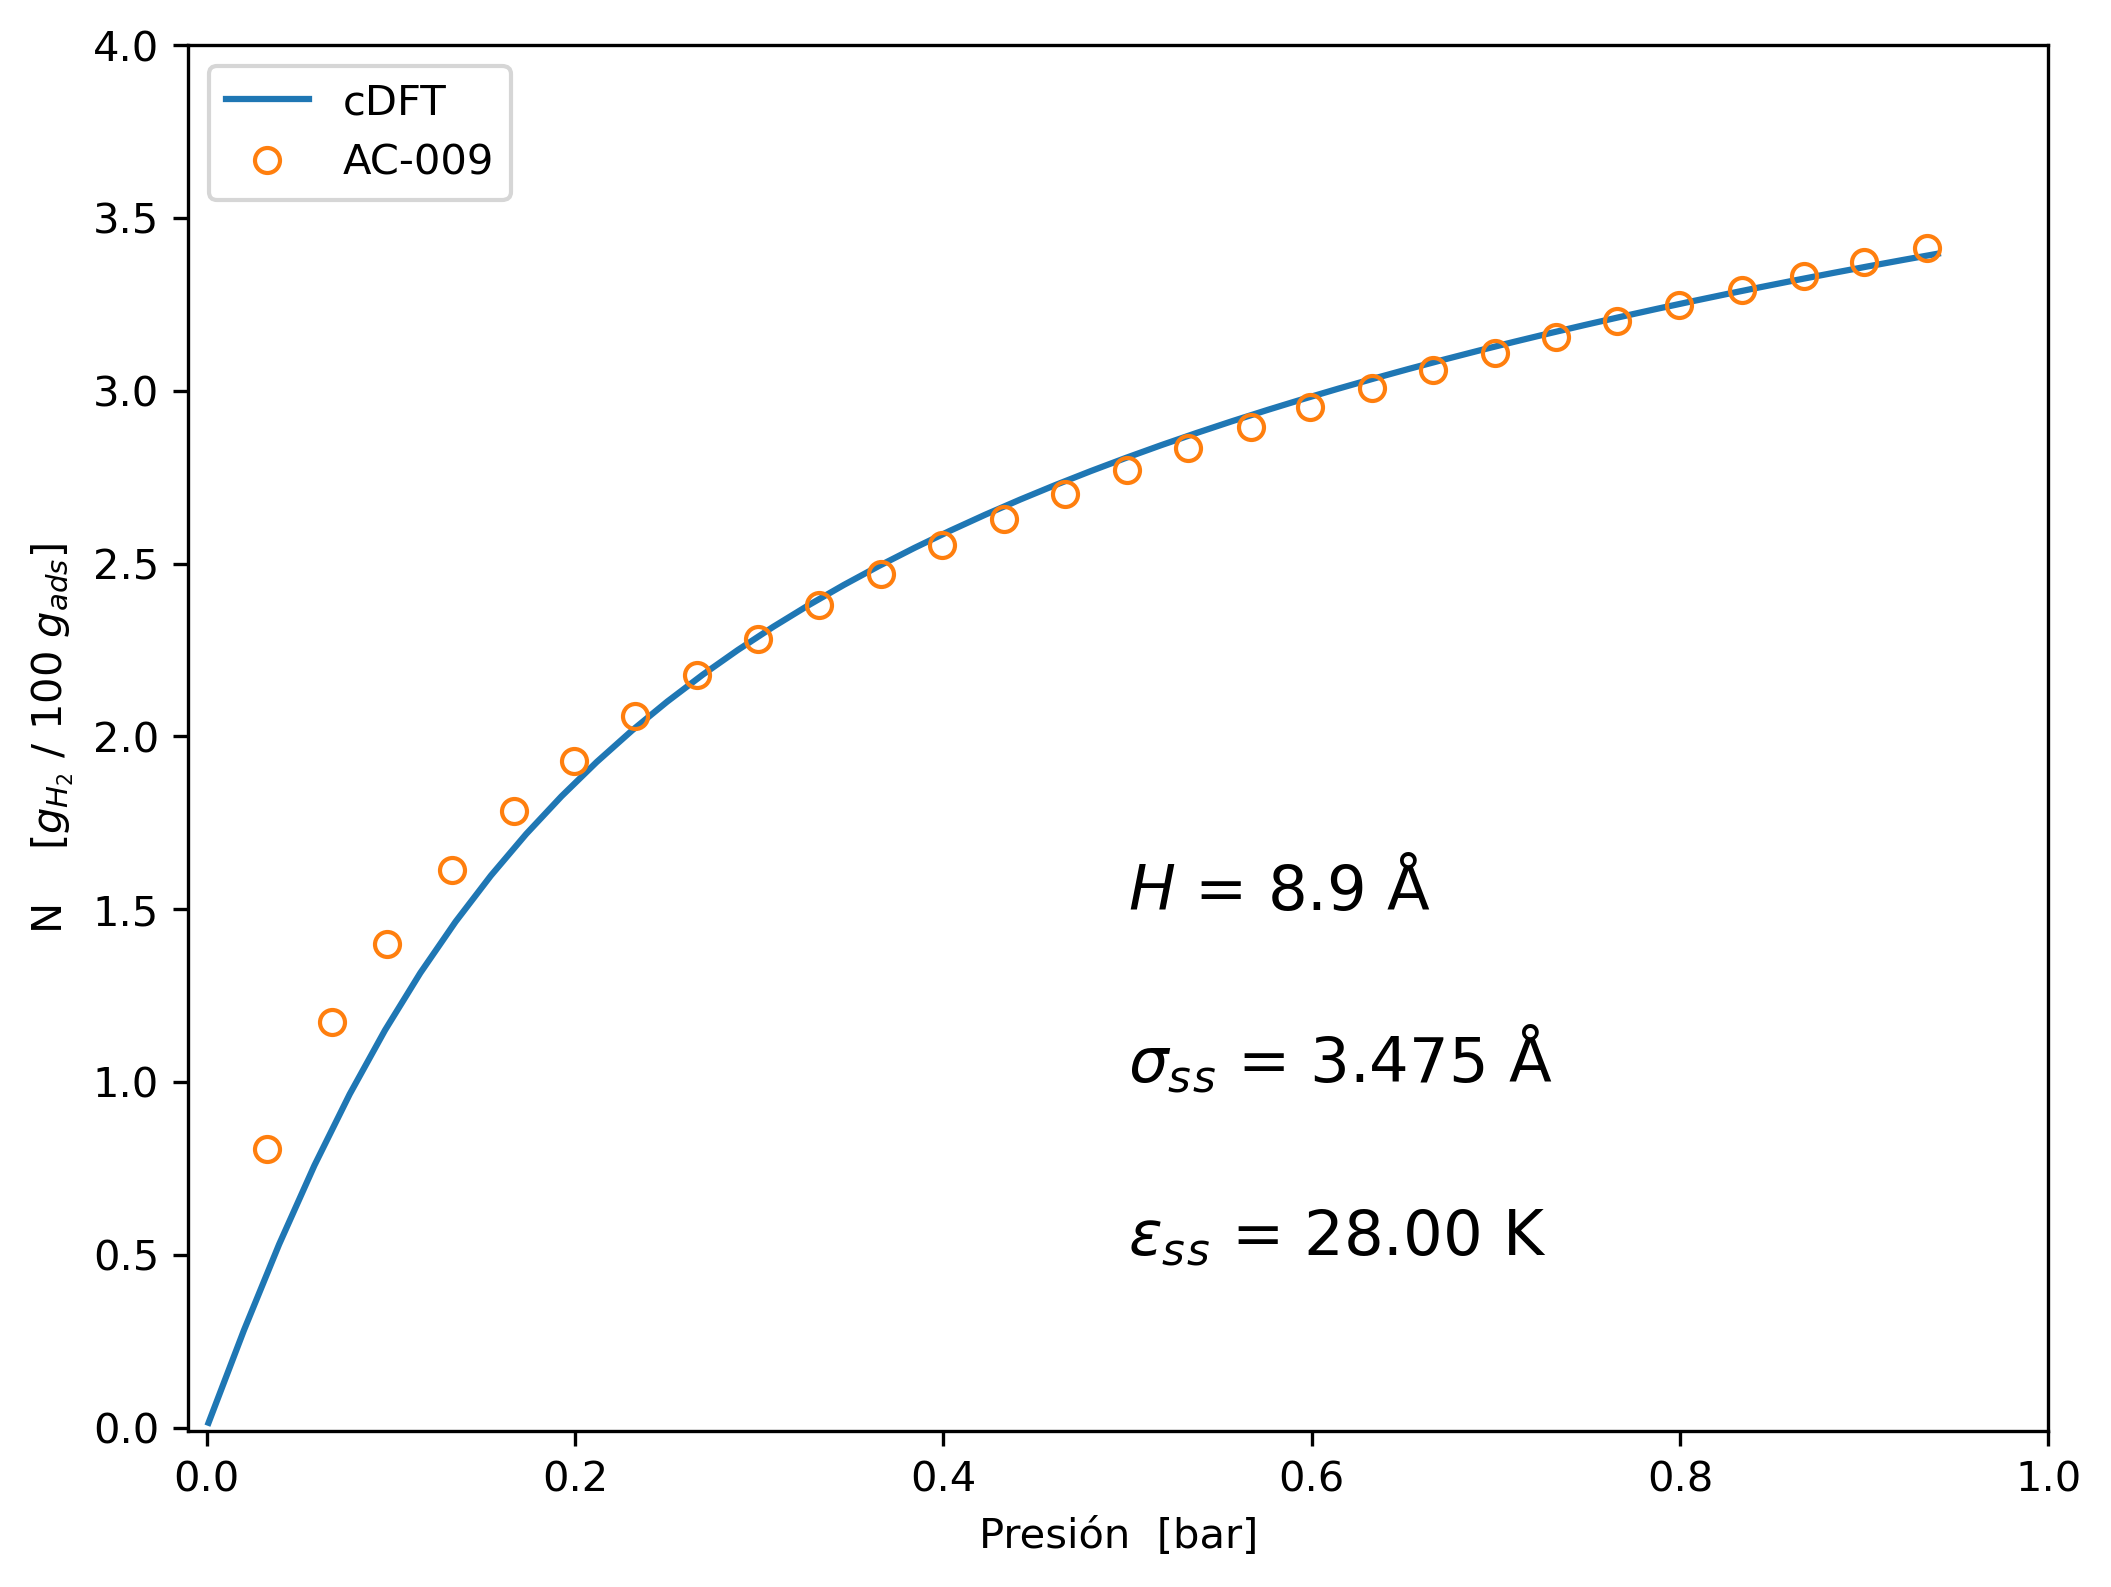

CPU times: user 1.51 s, sys: 96 ms, total: 1.6 s
Wall time: 1.65 s


In [22]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pore_siz = 8.9
BET      = 2600
Sigma    = 3.475
Epsilon  = 28

potential = ExternalPotential.Steele(Sigma, Epsilon, 0.114)  # https://doi.org/10.1021/la803666t
pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz*ANGSTROM, potential = potential)

for i in [77.1]:
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (i * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 0.94*BAR, 50), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MOL / METER**2)
    plt.plot(p, np.multiply(total_adsorption,2.016*BET*100), label="cDFT")

plt.plot(AbsP2_9, Weight_9, label="AC-009", marker="o", linestyle="None", mfc="None",color="tab:orange")

eq1 = (F"$H$ = {pore_siz} Å")
eq2 = (F"$\sigma_s$$_s$ = {Sigma:.3F} Å")
eq3 = (F"$\epsilon_s$$_s$ = {Epsilon:.2F} K")

plt.text(0.50, 1.5, eq1, color="k", fontsize=15)
plt.text(0.50, 1.0, eq2, color="k", fontsize=15)
plt.text(0.50, 0.5, eq3, color="k", fontsize=15)

plt.legend(loc="upper left", numpoints=1)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 4)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'N    $[g_{H_2}$ / 100 $g_{ads}]$')
#plt.suptitle('Comparación con resultados experimentales a 77 K')
plt.show()

Se realiza el mismo procedimiento anterior para reproducir los resultados experimentales de un segundo sólido adsorbente.

In [23]:
# Importar datos experimentales
df_7 = pd.read_csv('./744.csv',header= None)

RelPr_7 = df_7[0] # Presion relativa
AbsPr_7 = df_7[1] # Presion absoluta en mmHg
Qadso_7 = df_7[2] # Cantidad adsorbida en cm3/g STP
Weight_7= df_7[3] # Cantidad adsorbida en g H2/ g adsorbente
AbsP2_7 = AbsPr_7*0.00133322 # Presion absoluta en bar
#df.head()

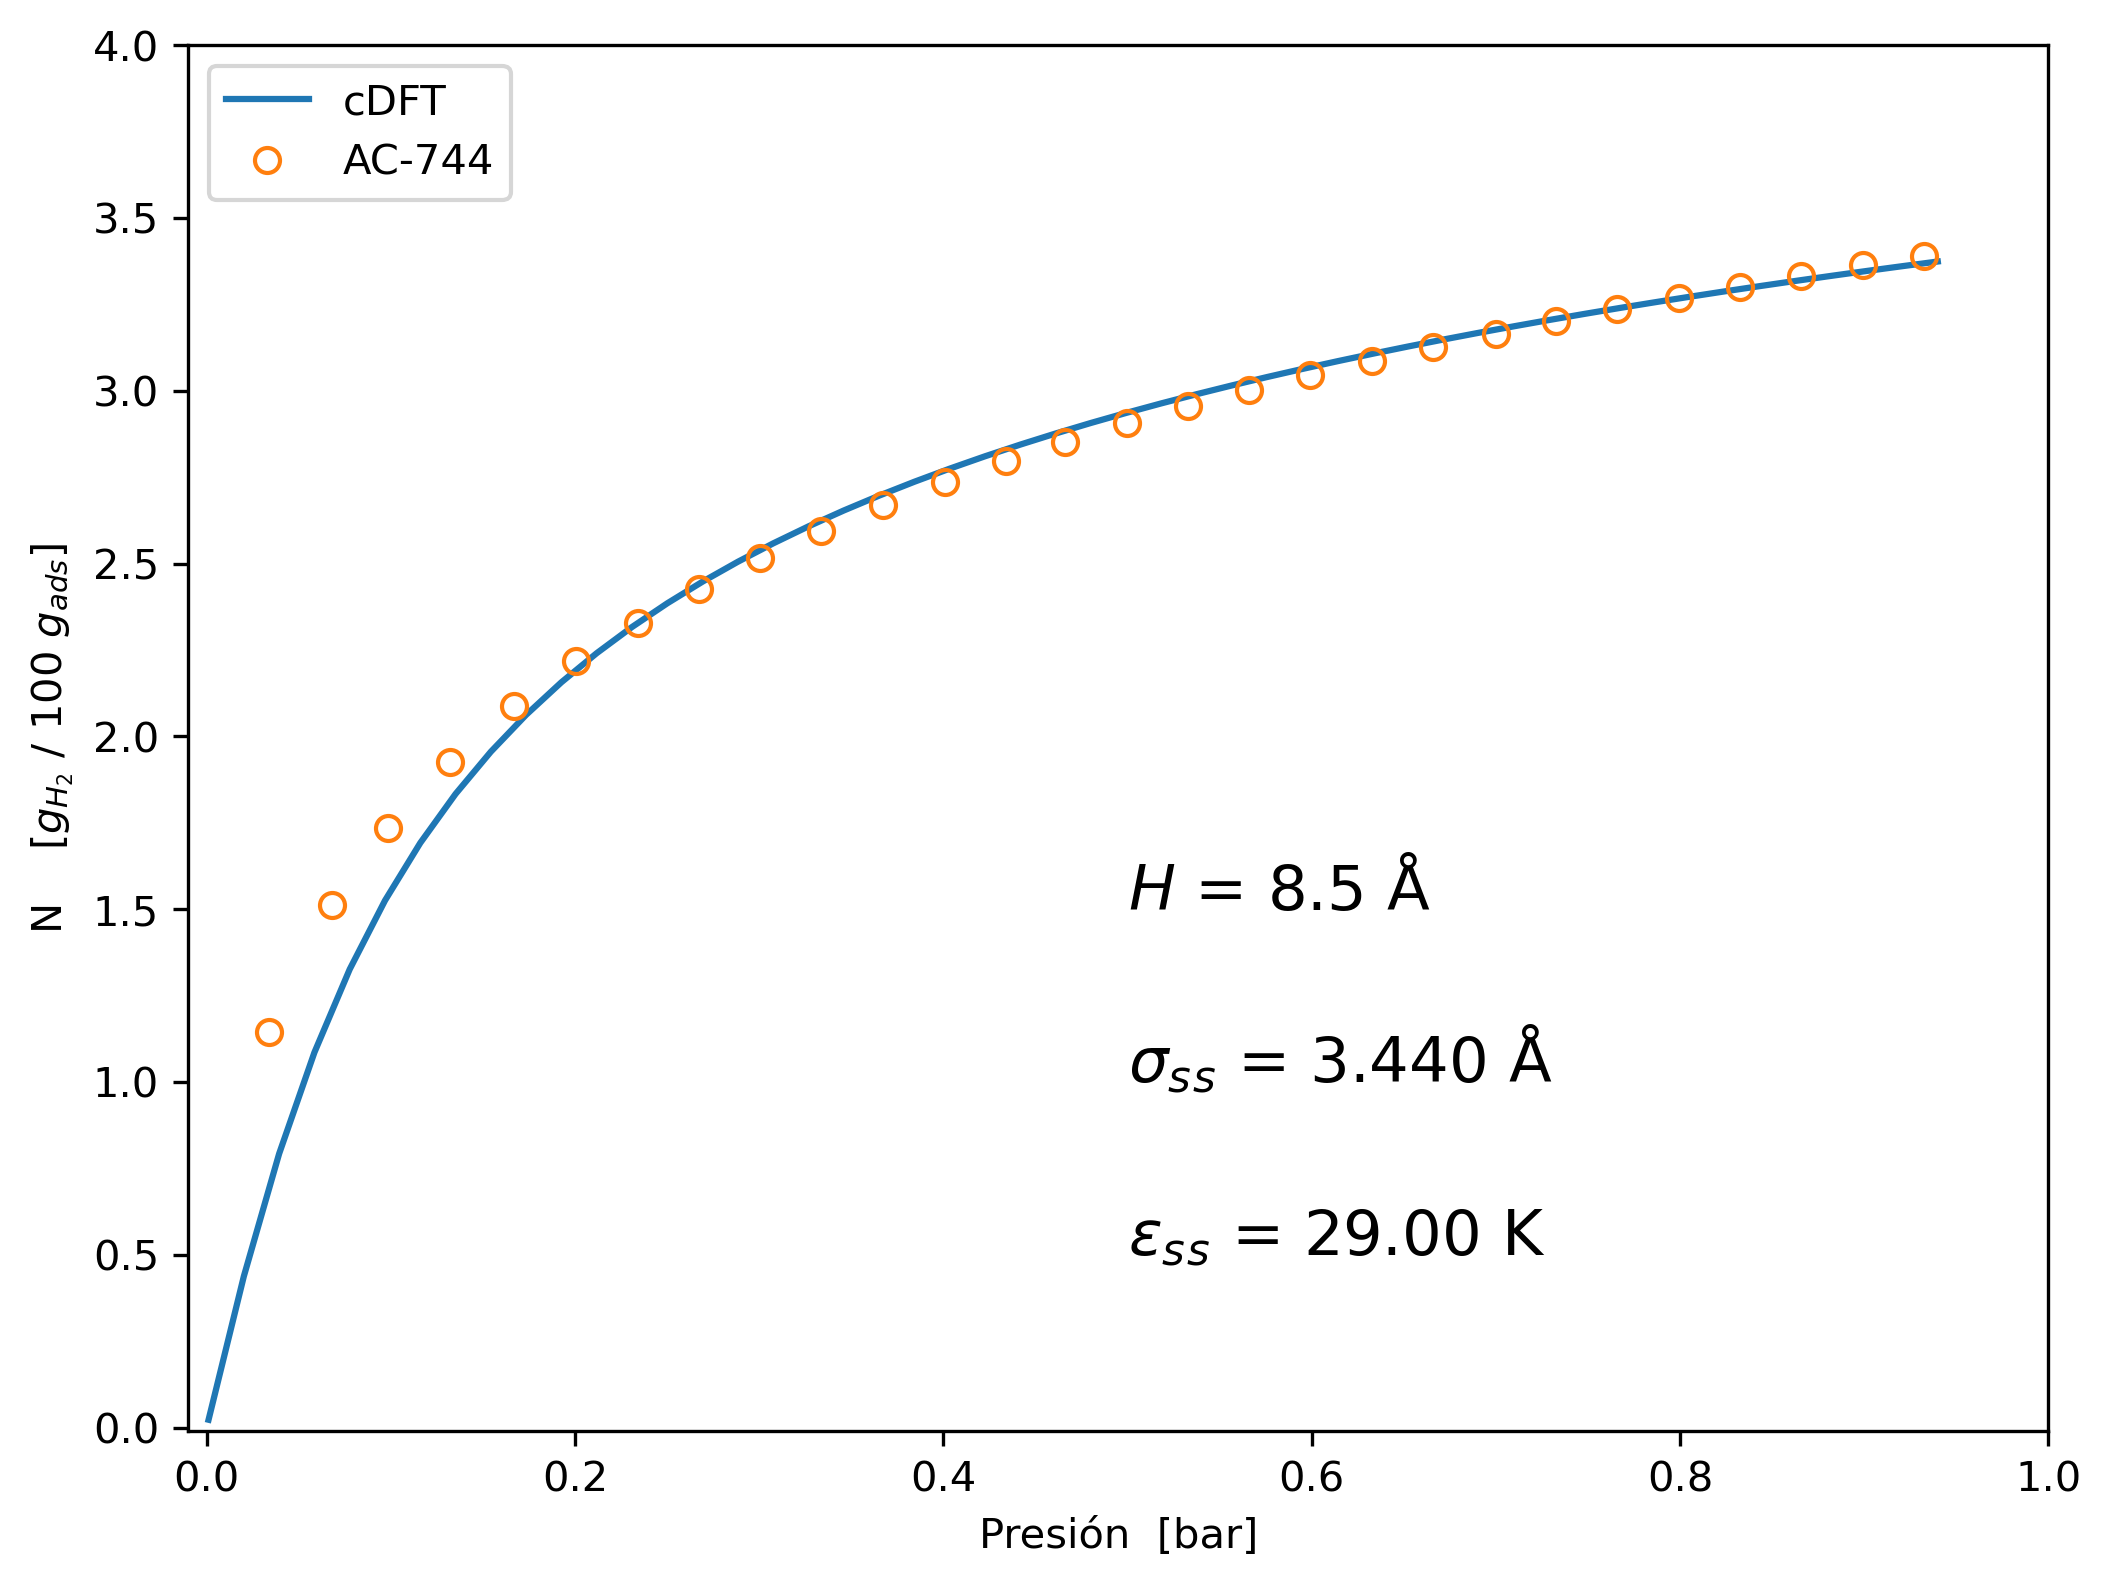

CPU times: user 1.49 s, sys: 71.9 ms, total: 1.56 s
Wall time: 1.54 s


In [24]:
%%time
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pore_siz = 8.5
BET      = 2700
Sigma    = 3.44
Epsilon  = 29

potential = ExternalPotential.Steele(Sigma, Epsilon, 0.114)  # https://doi.org/10.1021/la803666t
pore = Pore1D(geometry=Geometry.Cartesian, pore_size = pore_siz*ANGSTROM, potential = potential)

for i in [77.1]:
    isotherm = Adsorption1D.adsorption_isotherm(func, temperature = (i * KELVIN), 
                pressure = SIArray1.linspace(1.0e-3 * BAR, 0.94*BAR, 50), pore = pore)
    p = isotherm.pressure / BAR
    total_adsorption = isotherm.total_adsorption / (MOL / METER**2)
    plt.plot(p, np.multiply(total_adsorption,2.016*BET*100), label="cDFT")

plt.plot(AbsP2_7, Weight_7, label="AC-744", marker="o", linestyle="None", mfc="None",color="tab:orange")

eq1 = (F"$H$ = {pore_siz} Å")
eq2 = (F"$\sigma_s$$_s$ = {Sigma:.3F} Å")
eq3 = (F"$\epsilon_s$$_s$ = {Epsilon:.2F} K")

plt.text(0.50, 1.5, eq1, color="k", fontsize=15)
plt.text(0.50, 1.0, eq2, color="k", fontsize=15)
plt.text(0.50, 0.5, eq3, color="k", fontsize=15)

plt.legend(loc="upper left", numpoints=1)
plt.xlim(-0.01, 1)
plt.ylim(-0.01, 4)
plt.xlabel(r'Presión  [bar]')
plt.ylabel(r'N    $[g_{H_2}$ / 100 $g_{ads}]$')
#plt.suptitle('Comparación con resultados experimentales a 77 K')
plt.show()